# The (not so) Great Tetris AI ... thing?

David Besen
<br/>Joseph Griffith

TODO: 
1. we tried shortening the board height
1. tell reader what's in each section at the beginning of the section
1. Instructions for playing the animation on the console
1. Yiyuan Lee had very good results.  He used a random generator that prevents long sequences of S/Z pieces.


* check writing for accuracy

# Abstract
We were interested in training an AI to play Tetris without supplying any knowledge of the game, similar to how AlphaGo Zero taught itself to play Go. To that end we initially used reinforcement learning, using a neural network as the Q table, and the only reinforcement being that completing more moves is good. With this technique, the AI apparently learned something (evidenced by a gradual increase in average game lengths), but unfortunately not how to effectively play Tetris as we had hoped. Even after testing many neural network hidden layer configurations the AI seemed to fail to learn what it needed to to reliably complete lines to significantly extend the game. 

Eventually we achieved a modest spike in performance by **ditching the neural net and supplying some simple rules for selecting moves. This began as just having the AI select a move with the lowest overall height, then evolved into a balance of minimal height vs total number of holes left in the board after the piece would be placed.** After that we iterated through a number of height vs hole ratios to see what the best configuration was.



what, why, brief overview of methods and results

2-4 paragraphs

# Methods
Here are the steps that we took:
1. Build a simple tetris clone that outputs using stdout.
    * Leaving out time and calculating overhangs from the game to keep it somewhat simple
1. Make a random-placment AI that places the pieces in a random column with a random rotation.
1. Make an AI that searches all valid moves in a single game state, and chooses the move that puts the piece at the lowest possible position.
1. Make a reinforcement learning AI with a neural network for the Q table.  We didn't try to do reinforcement learning with a normal Q table because we thought it would use too much ram to be useful.  This first AI used column heights as part of the input to the neural network.
1. Tune the AI's parameters for best learning.
1. Change the neural network to use the entire board as input instead of just the column heights.  Surprisingly, this seemed to work better.
1. Make an AI that searches all valid moves in a single game state, and uses a combination of piece placment height and number of "holes" in each board to choose the best move.
1. Tune the parameters for that AI.


* 
* 
* steps taken, resources used (code, papers, [Russell and Norvig, 2014], ...)
* intermediate results 
* what each team member did (or its own section)

We wrote a play_game function that plays a single game of Tetris with this signature: ``play_game(self, strategyF, display=False, sleep=None)``.  The strategyF is a function that takes in a board and returns the best move for that board.  Display is whether or not to output the colorized tetris board to stdout, and sleep is a value for how long to wait between making moves (if you want to watch a game as it is being played).

In [2]:
import tetris
import ai
import importlib
import numpy as np

Here is an example of a game being played with randomly chosen moves.

In [2]:
tetris.Board().play_game(ai.randomMoveStrategy, True)

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

26

Here's the minimum height strategy.  It goes through all valid moves and picks the move with the lowest y position.  In the case of a tie, it chooses the first (i.e. leftmost) move.

In [3]:
tetris.Board().play_game(ai.minHeightStrategy, True)

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

48

And, here's the strategy that uses a combination of minimum height and number of holes.  This strategy had the best performance out of any strategy we tried.

In [4]:
tetris.Board().play_game(ai.holesAndHeightStrategy, True)

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|  |
|                    |
+---------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|  _|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|  _|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|                    |
|_|_|_|_|_|_|_|_|_|  |
+---------


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|    _|_|      |
|  _|_|_|  _|_|  _|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|    |
|  _|_|_|  _|_|_|    |
|  _|_|_|_|_|_|_|  _||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|  _|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_|

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|              _|_|  |
|      _|    _|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|    |
|              _|_|  |
|      _|    _|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|                    |
|                    |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|          _|  |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|    _|_|  _|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|  _|_|_|        _|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|        _|_|  |
|  _|_|_|    _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|  _|_|              |
|  _|_|      _|_|_|  |
|  _|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|  _|_|        _|_|_||
|  _|_|      _|_|_|_||
|  _|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|    _|_|            |
|_|  _|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|    _|_|          _||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|    _|    _|_||
|  _|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|_|            |
|  _|_|_|  _|    _|_||
|  _|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                  _||
|        _|  _|_|_|_||
|    _|_|_|_|_|_|_|_||
|  _|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|    _|_|          _||
|    _|_|_|  _|_|_|_||
|    _|_|_|_|_|_|_|_||
|  _|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|_|_|  _|_|          |
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|_|_|  _|_|          |
|_|_|  _|_|_|_|_|_|_||
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|  _|    _|      _|  |
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|              _|    |
|  _|    _|_|_|_|_|  |
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|  _|_|_|_|_|_|  _|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|  _|_|_|            |
|  _|_|_|_|_|_|  _|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|_|    _|    |
|  _|_|_|_|  _|_|    |
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|_|    _|_|_||
|  _|_|_|_|  _|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|_|_|_|  _|_|_|  _|  |
|_|_|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|        _|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|      _|_|_||
|  _|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|  _|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|            _|      |
|      _|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|  _|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|            _||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                _|_||
|_|_|_|        _|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|    _|  |
|_|_|    _|_|  _|_|  |
|_|_|    _|_|_|_|_|_||
|_|_|_|  _|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|    _|  |
|_|_|  _|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|      _|_|_|  |
|_|_|_|    _|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|      _|            |
|_|_|_|_|    _|_|_|  |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|              |
|_|_|_|  _|_|  _|    |
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|        _|_|        |
|_|_|_|  _|_|        |
|_|_|_|  _|_|  _|    |
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|_|  _|_|      |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|              _|_|  |
|  _|_|_|  _|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|        _|  |
|    _|_|_|      _|_||
|    _|_|_|  _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|  _|    _|  |
|    _|_|_|_|_|  _|_||
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|      _|    _|_|_|  |
|  _|_|_|_|  _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|            _|_|    |
|            _|_|_|  |
|      _|    _|_|_|  |
|  _|_|_|_|  _|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|        _|_|        |
|      _|_|_|_|_|    |
|    _|_|_|_|_|_|    |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|  _|    _|_|        |
|  _|_|_|_|_|_|_|    |
|  _|_|_|_|_|_|_|    |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|    _|_|            |		_|_|_|_|
|    _|_|            |		        
|    _|_|_|    _|    |		        
|    _|_|_|  _|_|_|_||		        
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|    _|_|            |
|    _|_|            |
|    _|_|_|    _|    |
|    _|_|_|  _|_|_|_||
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_


+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|  _|  _|_|  _|      |
|  _|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|  _|  _|_|  _|      |
|  _|_|_|_|  _|_|_|_||
|                    |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|    _|    _|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|    _|    _|_|_|_|  |
|  _|_|_|_|_|_|_|_|  |
|                    |
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|  _|            |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|_|          |
|  _|  _|_|_|        |
|_|_|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|    _|              |
|  _|_|_|_|_|        |
|_|_|_|_|_|_|_|  _|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|    _|          _|  |
|  _|_|_|_|_|  _|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|        _|          |
|  _|    _|_|        |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|_|          |
|  _|_|_|_|_|        |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|_|_|        _|_|    |
|_|_|        _|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|      |
|_|_|  _|    _|_|    |
|_|_|  _|_|  _|_|    |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_


+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|    _|  _|_|_|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|    _|  _|_|_|    _||
|_|_|_|_|  _|_|_|  _||
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|            _|    |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|            _|    |
|_|  _|_|_|_|_|_|_|_||
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|  _|_|_|_|_|        |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|  _|_|_|_|_|        |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|    |
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|    _|_|            |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|            |
|    _|_|            |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|                    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------


+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|  _|    _|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|_|_|    |
|_|_|  _|  _|_|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|          _|_|_|    |
|_|_|      _|_|_|    |
|_|_|      _|_|_|    |
|_|_|  _|  _|_|_|    |
|_|_|_|_|  _|_|_|    |
|_|_|_|_|  _|_|    _||
|_|_|_|_|  _|_|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|          _|_|_|    |
|_|_|      _|_|_|    |
|_|_|      _|_|_|    |
|_|_|  _|  _|_|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|  _|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|_|_|    |
|_|_|_|    _|_|_|    |
|_|_|_|_|  _|_|_|    |
|_|_|_|_|  _|_|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|_|_|    |
|_|_|_|    _|_|_|    |
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||


+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|      _|  _|_|      |
|_|_|_|_|_|_|_|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                  _||
|                  _||
|      _|  _|_|    _||
|_|_|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|_|      _|_|_|  |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|_|      _|_|_|  |
|                    |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+---------


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|  _|_|    _|_|_|    |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                _|  |
|              _|_|  |
|  _|_|    _|_|_|_|  |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_|

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|          _|        |		        
|          _|_|      |		        
|  _|_|  _|_|_|      |
|  _|_|  _|_|_|      |
|  _|_|  _|_|_|  _|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||
|_|_|_|_|  _|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|          _|        |		        
|          _|_|      |		        
|  _|_|  _|_|_|  _|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|_|_|_|  |
|  _|_|  _|_|  _|_|  |
|  _|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|  _|_|_|_|_|  |
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|_|_|_|_|  _||
|_|_|_|_|_|_|  _|_|_||

379

The play_ai_game() method trains the reinforcement-learning-with-neural-network-as-Q-table AI using parameters hardcoded in ai.py.  It then uses the trained AI to play one game that it displays.

In [5]:
ai.play_ai_game(100, [100]*40, 1, .98, 1, 1)

Played game 0 , lasted for 24 moves, epsilon is 1
Played game 1 , lasted for 25 moves, epsilon is 0.98
Played game 2 , lasted for 26 moves, epsilon is 0.9603999999999999
Played game 3 , lasted for 24 moves, epsilon is 0.9411919999999999
Played game 4 , lasted for 24 moves, epsilon is 0.9223681599999999
Played game 5 , lasted for 20 moves, epsilon is 0.9039207967999998
Played game 6 , lasted for 19 moves, epsilon is 0.8858423808639998
Played game 7 , lasted for 27 moves, epsilon is 0.8681255332467198
Played game 8 , lasted for 29 moves, epsilon is 0.8507630225817854
Played game 9 , lasted for 25 moves, epsilon is 0.8337477621301497
Played game 10 , lasted for 28 moves, epsilon is 0.8170728068875467
Played game 11 , lasted for 24 moves, epsilon is 0.8007313507497957
Played game 12 , lasted for 28 moves, epsilon is 0.7847167237347998
Played game 13 , lasted for 25 moves, epsilon is 0.7690223892601038
Played game 14 , lasted for 28 moves, epsilon is 0.7536419414749017
Played game 15 , last

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|    _|              |
|    _|              |
|  _|_|              |
|  _|_|              |
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|_|              |
|    _|              |
|  _|_|              |
|    _|              |

+--------------------+
|  _|_|_|            |		  _|    
|  _|_|_|            |		_|_|    
|  _|_|              |		  _|    
|  _|_|              |		        
|  _|                |
|  _|                |
|  _|_|_|            |
|    _|              |
|  _|_|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|    _|              |
|    _|            _||
|  _|_|  _|_|_|  _|_||
|  _|_|    _|    _|  |
+--------------------+

+--------------------+
|  _|_|_|            |		_|_|_|_|
|  _|_|_|            |		        
|  _|_|              |		        
|  _|_|              |		        
|  _|                |
|  _|                |
|  _|_|_|            |
|    _|              |
|  _|_|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|  _|_|              |
|    _|              |
|  _|_|              |
|    _|  _|_|_|      |

+--------------------+
|  _|_|_|            |		_|_|    
|  _|_|_|_|_|        |		_|_|    
|  _|_|  _|          |		        
|  _|_|  _|          |		        
|  _|    _|          |
|  _|    _|          |
|  _|_|_|_|          |
|    _|  _|          |
|  _|_|  _|_|_|      |
|  _|_|    _|        |
|  _|_|    _|        |
|    _|  _|_|        |
|  _|_|  _|          |
|  _|_|  _|_|        |
|    _|    _|        |
|  _|_|    _|        |
|_|  _|  _|_|_|      |
|_|  _|    _|      _||
|_|_|_|  _|_|_|  _|_||
|_|_|_|    _|    _|  |
+--------------------+

+--------------------+
|  _|_|_|            |		_|_|    
|  _|_|_|_|_|        |		_|_|    
|  _|_|  _|          |		        
|  _|_|  _|          |		        
|  _|    _|          |
|  _|    _|          |
|  _|_|_|_|          |
|    _|  _|          |
|  _|_|  _|_|_|      |
|  _|_|    _|        |
|  _|_|    _|        |
|    _|  _|_|        |
|  _|_|  _|          |
|  _|_|  _|_|        |
|    _|    _|        |
|  _|_|    _|        |
|_|  _|  _|_|_|_|_|  |

+--------------------+
|  _|_|_|            |		  _|    
|  _|_|_|_|_|        |		_|_|    
|  _|_|  _|          |		  _|    
|  _|_|  _|          |		        
|  _|    _|          |
|  _|    _|          |
|  _|_|_|_|      _|_||
|    _|  _|        _||
|  _|_|  _|_|_|    _||
|  _|_|    _|    _|_||
|  _|_|    _|    _|  |
|    _|  _|_|    _|  |
|  _|_|  _|      _|_||
|  _|_|  _|_|    _|_||
|    _|    _|    _|_||
|  _|_|    _|    _|_||
|_|  _|  _|_|_|_|_|  |
|_|  _|    _|  _|_|_||
|_|_|_|  _|_|_|  _|_||
|_|_|_|    _|    _|  |
+--------------------+

+--------------------+
|  _|_|_|            |		    _|  
|  _|_|_|_|_|        |		_|_|_|  
|  _|_|  _|          |		        
|  _|_|  _|          |		        
|  _|    _|    _|_|_||
|  _|    _|      _|  |
|  _|_|_|_|      _|_||
|    _|  _|        _||
|  _|_|  _|_|_|    _||
|  _|_|    _|    _|_||
|  _|_|    _|    _|  |
|    _|  _|_|    _|  |
|  _|_|  _|      _|_||
|  _|_|  _|_|    _|_||
|    _|    _|    _|_||
|  _|_|    _|    _|_||
|_|  _|  _|_|_|_|_|  |

+--------------------+
|  _|_|_|  _|_|_|    |		        
|  _|_|_|_|_|_|  _|_||		        
|  _|_|  _|  _|_|  _||		        
|  _|_|  _|  _|_|  _||		        
|  _|    _|    _|_|_||
|  _|    _|      _|  |
|  _|_|_|_|      _|_||
|    _|  _|        _||
|  _|_|  _|_|_|    _||
|  _|_|    _|    _|_||
|  _|_|    _|    _|  |
|    _|  _|_|    _|  |
|_|_|_|  _|      _|_||
|_|_|_|  _|_|    _|_||
|_|  _|    _|    _|_||
|_|_|_|    _|    _|_||
|_|  _|  _|_|_|_|_|  |
|_|  _|    _|  _|_|_||
|_|_|_|  _|_|_|  _|_||
|_|_|_|    _|    _|  |
+--------------------+

28 moves


# results
show all results - 

graphs, etc

We tried the train method with a variety of parameters.  We found (surprisingly!) that the best number of training iterations and replays was 1 and 1.  If we increased either past 1, the training speed (in terms of performance per time spent training, not in terms of performance per number of games played) seemed to get worse.  We ran the train method for 50,000 games with 1 training iteration, 1 replay, epsilon decay factor .999, and ``[50, 20, 10, 2, 10, 20, 50]`` as the hidden layers. This took several hours to run.  We saved the game lengths into a file:

In [137]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
def graph(file):
    game_lengths = np.loadtxt(file)
    print(len(game_lengths), max(game_lengths), min(game_lengths), sum(game_lengths)/len(game_lengths))
    plt.figure(figsize=(16,10))
    plt.margins(0, .045)
    plt.ylabel("Game length (# moves)")
    plt.xlabel("Game number")
    plt.plot(game_lengths, '.', ms=4, color=(.3, .5, .9));

    # Add a trendline to the graph
    p = np.poly1d(np.polyfit(range(len(game_lengths)), game_lengths, 1))
    plt.plot(p(range(len(game_lengths))),"--", dashes=(.001, 2), lw=3, color=(1, .1, .1), dash_capstyle="round");

50000 55.0 14.0 31.0518


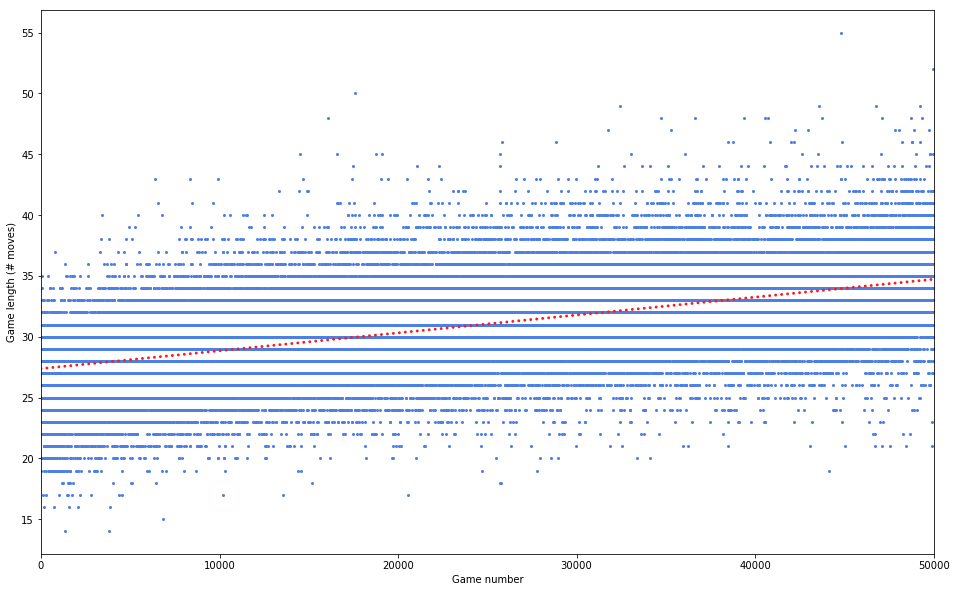

In [140]:
graph("ai-game-lengths.txt")

As you can see, the game lengths did increase as the number of games played increased, but there wasn't a significant change.  It should be possible for the AI to play very long games (over 1000 moves), but the longest game we saw was 55 moves.  Perhaps if we continued to train it it would continue to improve.  When we watched the trained AI play a game, it effectively filled the board with pieces, but it didn't fill very many lines (it did fill some!).  It could be that it learned that filling the space more effectively leads to longer games, but it didn't yet learn that getting lines leads to longer games, or how to get lines.

When we ran the AI with just "I" and "O" pieces (the long piece and the square piece), it did get some very long games (>300 lines).  When we watched those games, it filled the board with pieces, and then started getting lines near the top of the board.  Perhaps with more training time, it could learn to get lines lower, instead of higher up.

Since the AI was taking so long to train, we decided to go back to simple greedy strategies.  We tried a strategy that tries every valid move, counts the number of holes in the board, and balances that against the height the piece is placed at.  Lower is better, and fewer holes are better.  This strategy seemed to work quite well (we got game lengths over 300 moves), so we decided to try to tune it for maximum performance.

For tuning the holesAndHeightStrategy, we tried playing a set of games with different balance factors.  For each balance factor, we played 30 games, and collected the minimum, maximum, and average game lengths.  (It took about 52 minutes to run.)

In [154]:
def graphResults(file, games, spacing, labelType):
    with open(file) as f:
        firstLine = f.readline()
        #print(firstLine)
        data = np.loadtxt(f,delimiter=",")
    X = data[:,1]
    avg = data[:,4]
    mins = data[:,2]
    maxs = data[:,3]

    plt.figure(figsize=(16,10))
    plt.margins(.02, .02)
    plt.ylabel("Min, max, and average game length over " + str(games) + " games (# moves)")
    plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")

    width = (max(X) - min(X)) / (len(X)-1)
    gap = spacing
    # Note due to the way plt.bar works we have to pass maxs-mins in for the max value.
    # The mins value moves the whole bar up, not just the bottom of the bar.
    if labelType == 1:
        labels = [round(X[i], 3) for i in range(len(X)) ]
    if labelType == 2:
        labels = [round(X[i], 3) if i%2==0 else '' for i in range(len(X)) ]
    plt.bar(X, maxs-mins, width-gap, mins, color=(.75, .8, .95), tick_label=labels)
    plt.plot(X, avg, "-", color=(1, .3, .3))
    plt.ylim(ymin=0);

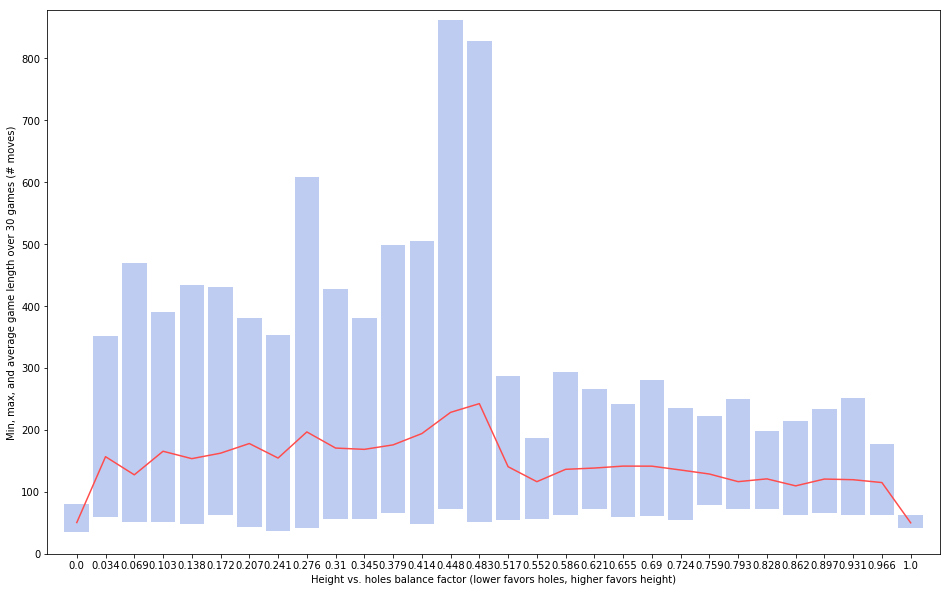

In [155]:
graphResults("holes-and-height-scan-0-1.txt", 30, .005, 1)

There's a big jump from 0 to slightly larger than 0, and a big drop from slightly less than 1 to 1.0.  Also, it looks like something interesting happened around 0.5.  Is it just random noise?  Let's try playing another set of games zoomed in on that range.

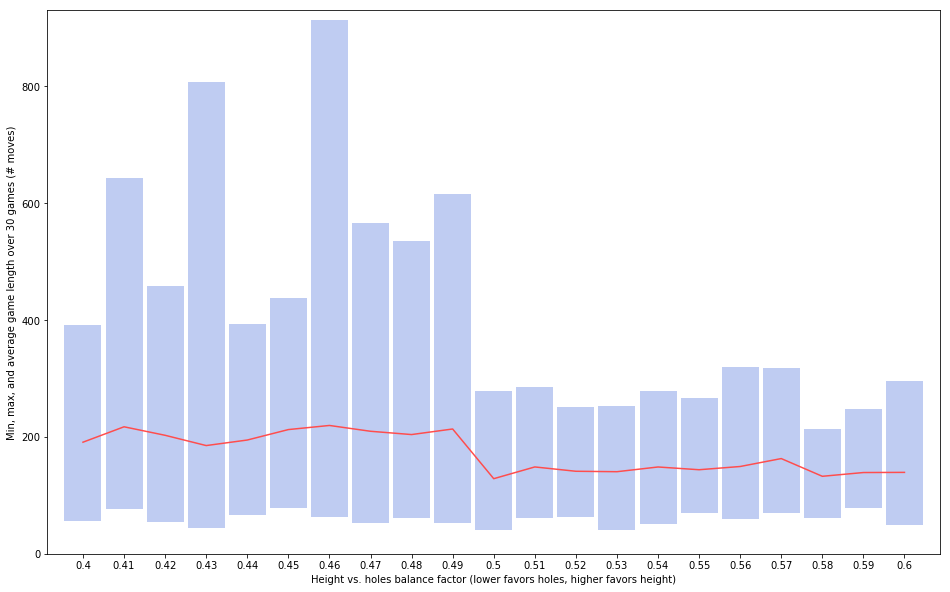

In [156]:
graphResults("holes-and-height-scan-.4-.6.txt", 30, .001, 1)

Looks like there is a lot of random noise, especially in the max value.  However, there was still a significant decrease between 0.49 and 0.5.  In both graphs, a value of around 0.46-0.48 seems best.

* how about focussing even more on .4-.5 and playing 100 games of each to try to normalize those results a bit?

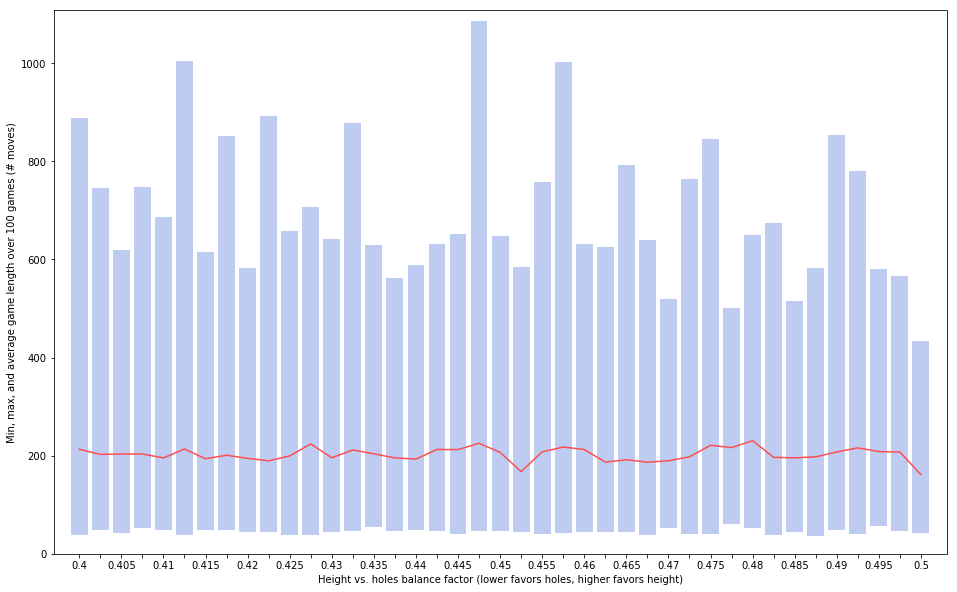

In [161]:
#graphResults("holes-and-height-scan-.4-.5.txt", 100, .001, 1)
graphResults("holes-and-height-scan-.4-.5.txt", 100, .0005, 2)

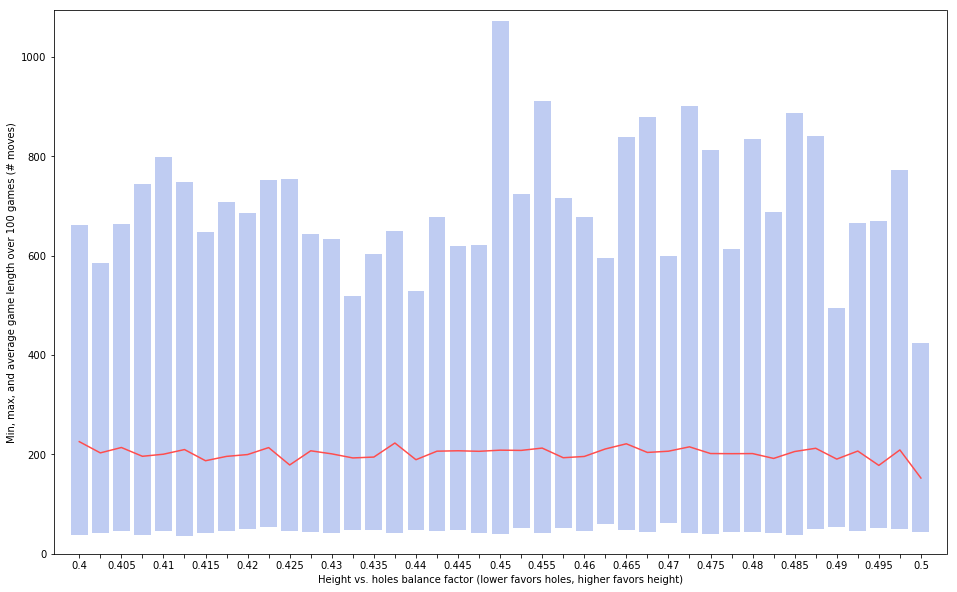

In [162]:
graphResults("holes-and-height-scan-.4-.5b.txt", 100, .0005, 2)

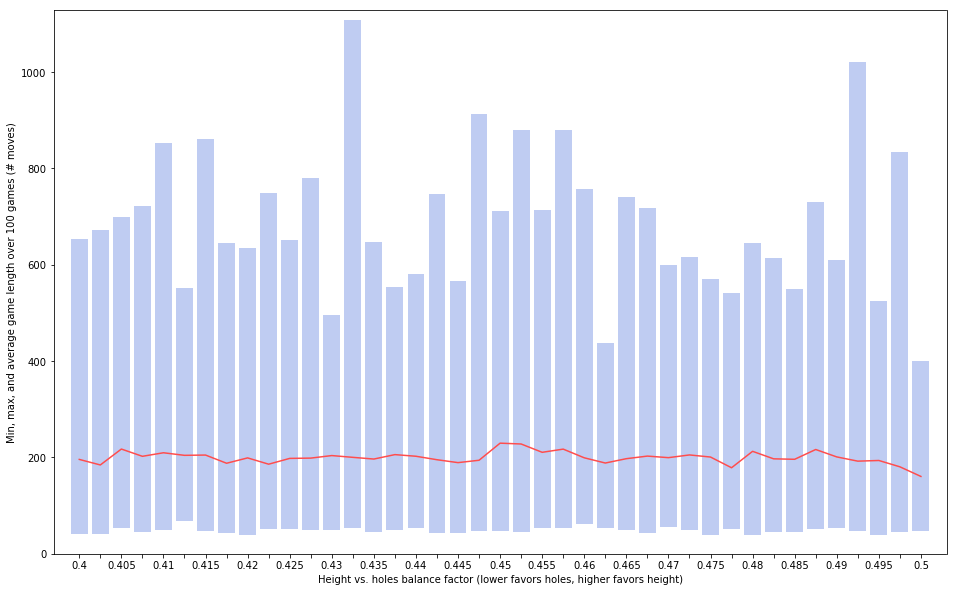

In [163]:
graphResults("holes-and-height-scan-.4-.5c.txt", 100, .0005, 2)

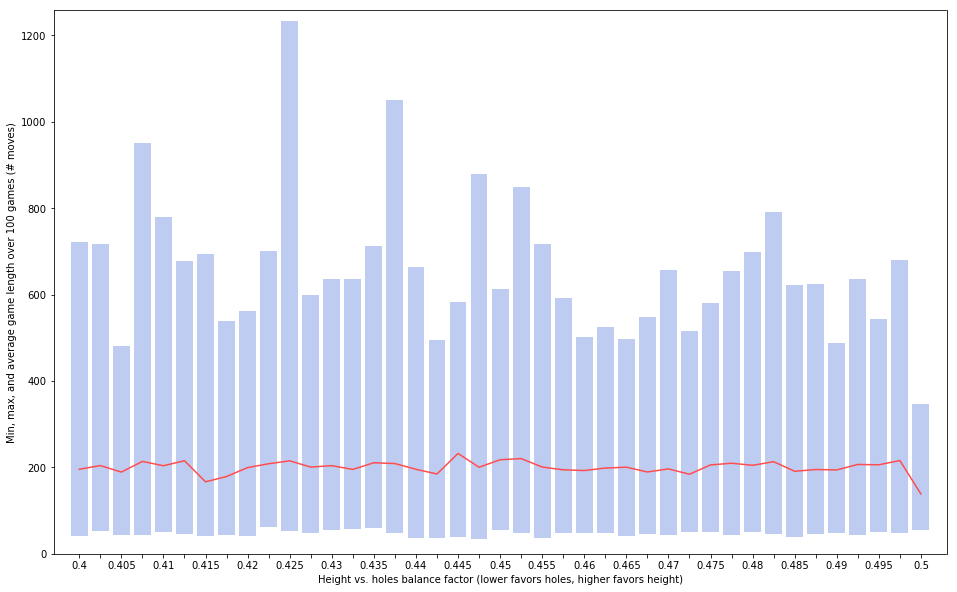

In [164]:
graphResults("holes-and-height-scan-.4-.5d.txt", 100, .0005, 2)

numGames, factor, min, max, avg



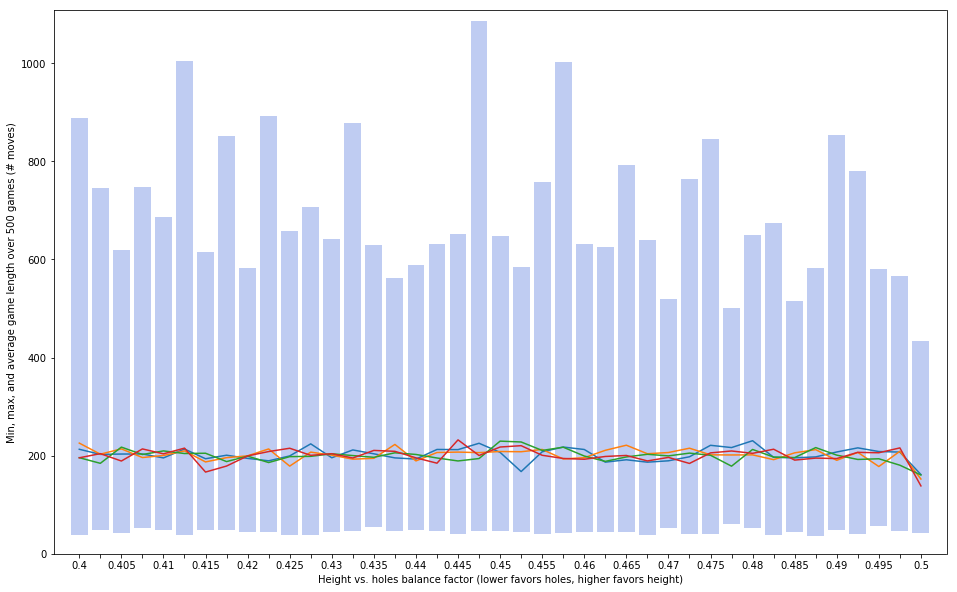

In [171]:
with open('holes-and-height-scan-.4-.5.txt') as f:
    firstLine = f.readline()
    print(firstLine)
    A = np.loadtxt(f,delimiter=",")
with open('holes-and-height-scan-.4-.5b.txt') as f:
    firstLine = f.readline()
    B = np.loadtxt(f,delimiter=",")
with open('holes-and-height-scan-.4-.5c.txt') as f:
    firstLine = f.readline()
    C = np.loadtxt(f,delimiter=",")
with open('holes-and-height-scan-.4-.5d.txt') as f:
    firstLine = f.readline()
    D = np.loadtxt(f,delimiter=",")
X = A[:,1]
avg = A[:,4]
mins = A[:,2]
maxs = A[:,3]
plt.figure(figsize=(16,10))
plt.margins(.02, .02)
plt.ylabel("Min, max, and average game length over 500 games (# moves)")
plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")

width = (max(X) - min(X)) / (len(X)-1)
gap = .0005
# Note due to the way plt.bar works we have to pass maxs-mins in for the max value.
# The mins value moves the whole bar up, not just the bottom of the bar.
labels = [round(X[i], 3) if i%2==0 else '' for i in range(len(X)) ]
plt.bar(X, maxs-mins, width-gap, mins, color=(.75, .8, .95), tick_label=labels)
plt.plot(X, A[:,4], "-")
plt.plot(X, B[:,4], "-")
plt.plot(X, C[:,4], "-")
plt.plot(X, D[:,4], "-")
plt.ylim(ymin=0);

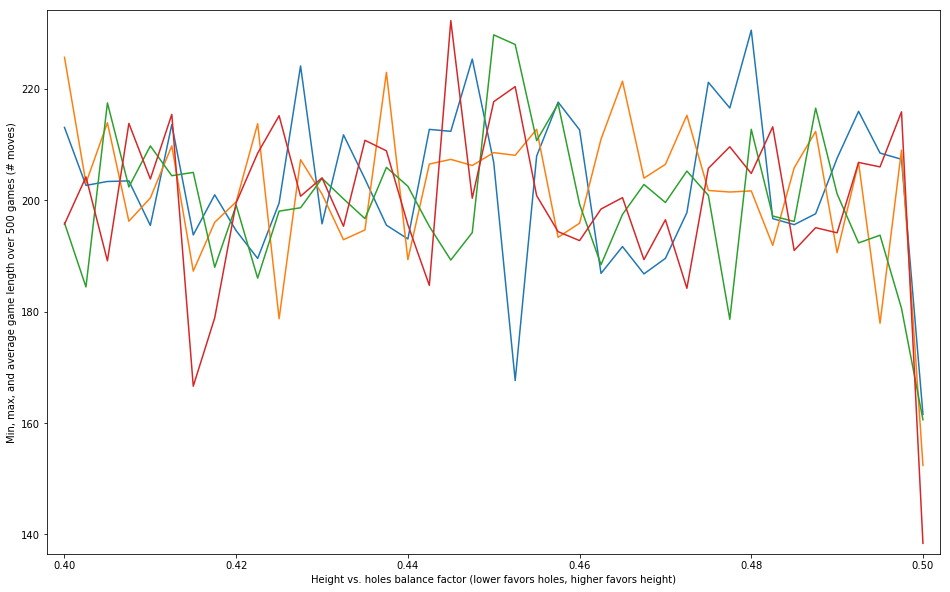

In [174]:
plt.figure(figsize=(16,10))
plt.margins(.02, .02)
plt.ylabel("Min, max, and average game length over 500 games (# moves)")
plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")
plt.plot(X, A[:,4], "-")
plt.plot(X, B[:,4], "-")
plt.plot(X, C[:,4], "-")
plt.plot(X, D[:,4], "-");

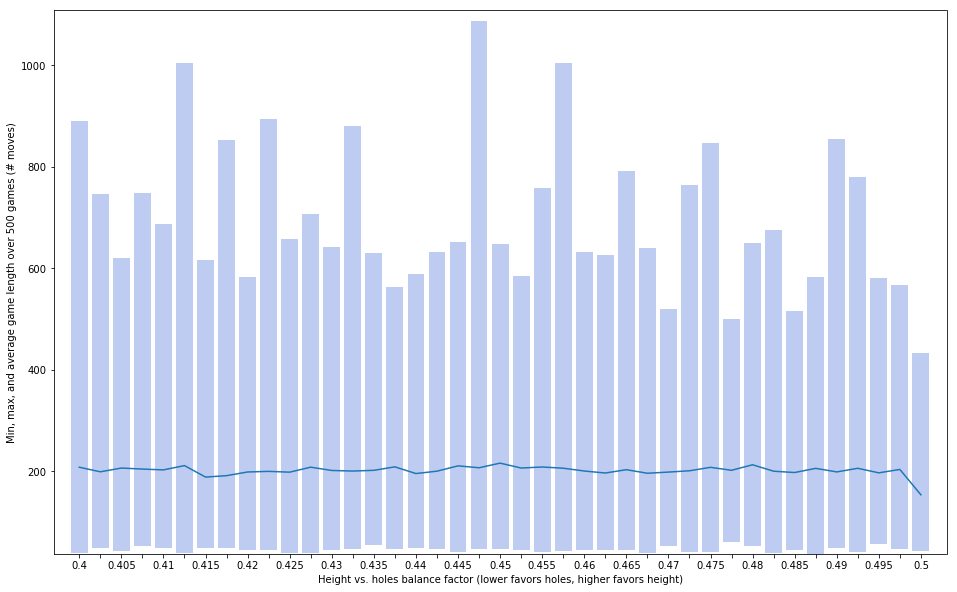

In [178]:
ABCD = copy(A)
for i in range(len(A)):
    if A[i,1] == B[i,1]:
        ABCD[i,2] = B[i,2] if A[i,2] > B[i,2] else A[i,2]
        ABCD[i,3] = B[i,3] if A[i,3] < B[i,3] else A[i,3]
    if A[i,1] == C[i,1]:
        ABCD[i,2] = C[i,2] if A[i,2] > C[i,2] else A[i,2]
        ABCD[i,3] = C[i,3] if A[i,3] < C[i,3] else A[i,3]
    if A[i,1] == D[i,1]:
        ABCD[i,2] = D[i,2] if A[i,2] > D[i,2] else A[i,2]
        ABCD[i,3] = D[i,3] if A[i,3] < D[i,3] else A[i,3]
    ABCD[i,4] = (A[i,4]+B[i,4]+C[i,4]+D[i,4])/4
plt.figure(figsize=(16,10))
plt.margins(.02, .02)
plt.ylabel("Min, max, and average game length over 500 games (# moves)")
plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")
labels = [round(X[i], 3) if i%2==0 else '' for i in range(len(X)) ]
plt.bar(X, maxs-mins, width-gap, mins, color=(.75, .8, .95), tick_label=labels)
plt.plot(X, ABCD[:,4], "-");
#plt.plot(X, A[:,4], "-")
#plt.plot(X, B[:,4], "-")
#plt.plot(X, C[:,4], "-")
#plt.plot(X, D[:,4], "-");

50000 50.0 15.0 30.7961


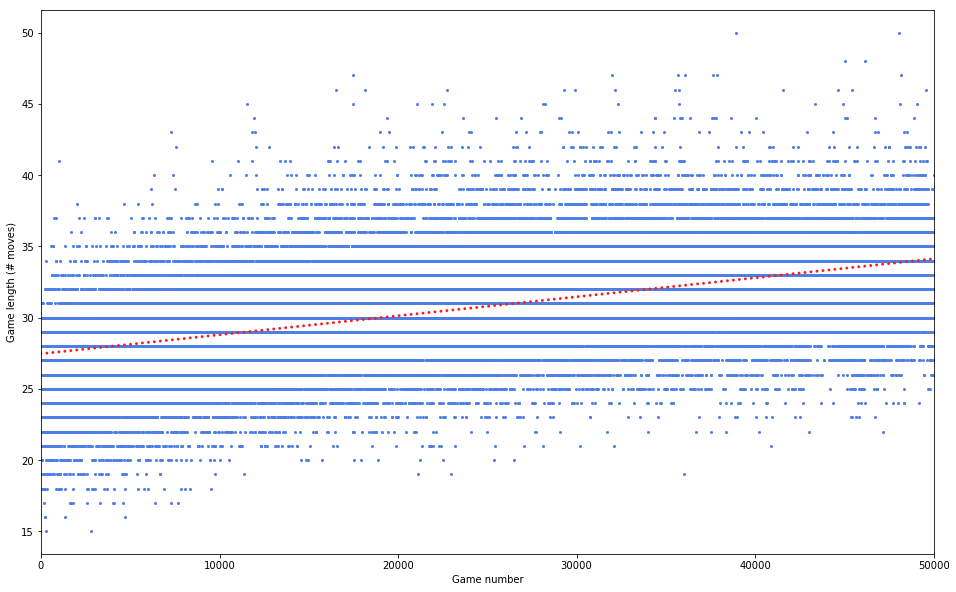

In [143]:
#play_ai_game(50000, [50, 20, 10, 2, 10, 20, 50], 1, .9999)
graph("50k9999")

100000 51.0 14.0 30.13067


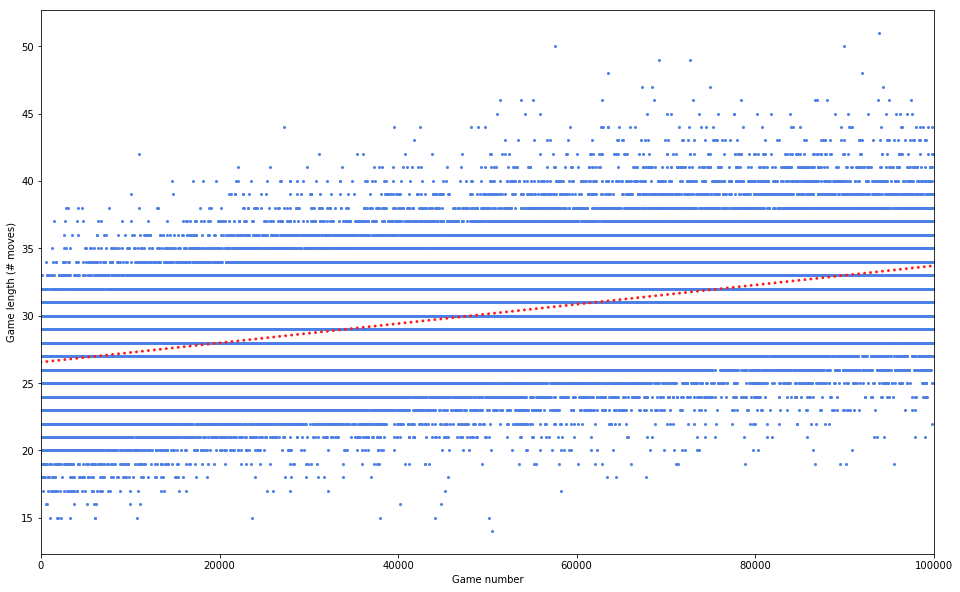

In [144]:
#play_ai_game(100000, [50, 20, 10, 2, 10, 20, 50], 1, .99997)
graph("100k99997")

500000 53.0 13.0 30.280138


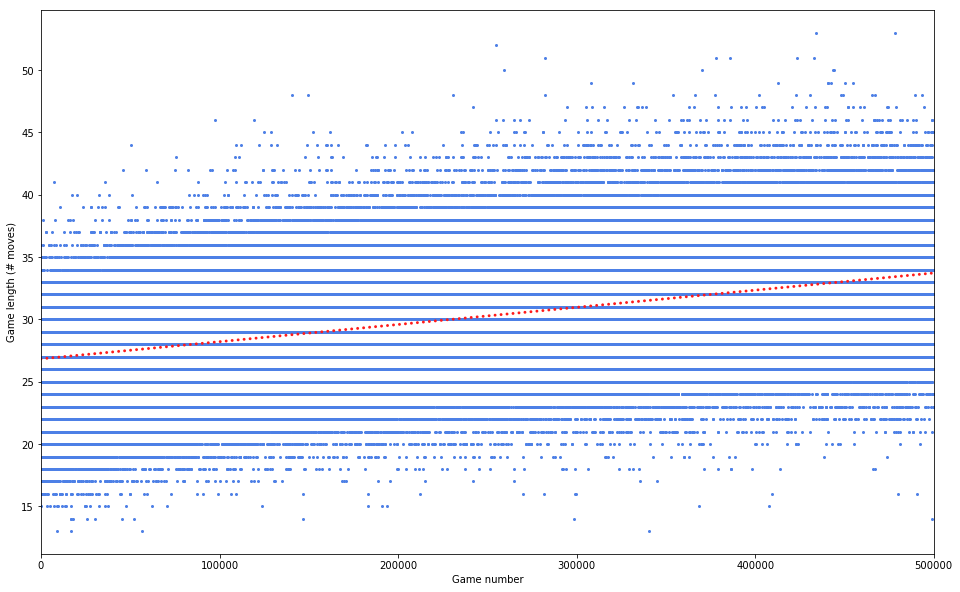

In [146]:
#play_ai_game(500000, [50, 20, 10, 2, 10, 20, 50], 1, .999995)
graph('500k999995')

500000 48.0 11.0 27.134796


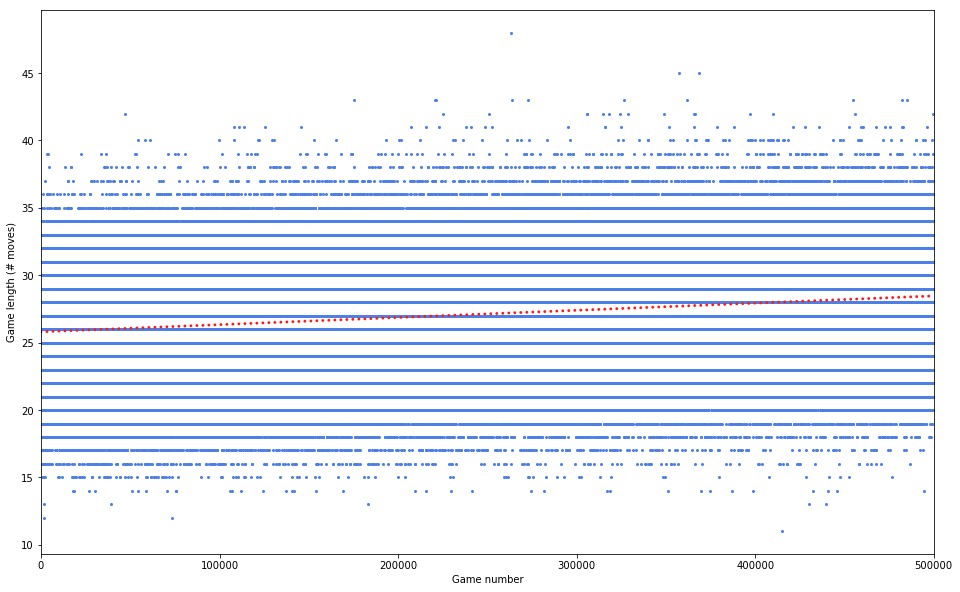

In [147]:
#play_ai_game(500000, [500], 1, .999999)
graph('500k-500-999999')

In [149]:
from random import randrange as rand
from copy import copy
results = []
for i in range(100):
    #results.append(rand(0, 3))
    layers = []
    for j in range(rand(1, 21)):
        layers.append(rand(1, 101))
    #rev = copy(layers)
    #rev.reverse()
    #if rand(0, 2) == 0:
    #    layers2 = layers + rev
    #else:
    #    layers2 = rev + layers
    it = rand(1, 31)
    rep = rand(1, 31)
    #print('layers:', layers, 'layers2:', layers2, 'IT:', it, 'REP:', rep)
    print('layers:', layers, 'IT:', it, 'REP:', rep)
    results.append(ai.play_ai_game(1000, layers, 1, .999, 1, 1))
results

layers: [9] IT: 15 REP: 4
Played game 0 , lasted for 24 moves, epsilon is 1
Played game 1 , lasted for 25 moves, epsilon is 0.999
Played game 2 , lasted for 22 moves, epsilon is 0.998001
Played game 3 , lasted for 27 moves, epsilon is 0.997002999
Played game 4 , lasted for 30 moves, epsilon is 0.996005996001
Played game 5 , lasted for 27 moves, epsilon is 0.995009990004999
Played game 6 , lasted for 29 moves, epsilon is 0.994014980014994
Played game 7 , lasted for 31 moves, epsilon is 0.993020965034979
Played game 8 , lasted for 26 moves, epsilon is 0.9920279440699441
Played game 9 , lasted for 22 moves, epsilon is 0.9910359161258742
Played game 10 , lasted for 26 moves, epsilon is 0.9900448802097482
Played game 11 , lasted for 22 moves, epsilon is 0.9890548353295385
Played game 12 , lasted for 20 moves, epsilon is 0.988065780494209
Played game 13 , lasted for 25 moves, epsilon is 0.9870777147137147
Played game 14 , lasted for 26 moves, epsilon is 0.986090636999001
Played game 15 , las

Played game 121 , lasted for 25 moves, epsilon is 0.8859803203984784
Played game 122 , lasted for 26 moves, epsilon is 0.88509434007808
Played game 123 , lasted for 26 moves, epsilon is 0.8842092457380019
Played game 124 , lasted for 29 moves, epsilon is 0.8833250364922639
Played game 125 , lasted for 27 moves, epsilon is 0.8824417114557717
Played game 126 , lasted for 31 moves, epsilon is 0.8815592697443159
Played game 127 , lasted for 24 moves, epsilon is 0.8806777104745716
Played game 128 , lasted for 24 moves, epsilon is 0.8797970327640969
Played game 129 , lasted for 23 moves, epsilon is 0.8789172357313328
Played game 130 , lasted for 28 moves, epsilon is 0.8780383184956015
Played game 131 , lasted for 32 moves, epsilon is 0.8771602801771059
Played game 132 , lasted for 18 moves, epsilon is 0.8762831198969288
Played game 133 , lasted for 26 moves, epsilon is 0.8754068367770318
Played game 134 , lasted for 28 moves, epsilon is 0.8745314299402548
Played game 135 , lasted for 27 move

Played game 240 , lasted for 25 moves, epsilon is 0.7865334084168147
Played game 241 , lasted for 25 moves, epsilon is 0.7857468750083979
Played game 242 , lasted for 22 moves, epsilon is 0.7849611281333895
Played game 243 , lasted for 27 moves, epsilon is 0.784176167005256
Played game 244 , lasted for 27 moves, epsilon is 0.7833919908382508
Played game 245 , lasted for 27 moves, epsilon is 0.7826085988474126
Played game 246 , lasted for 31 moves, epsilon is 0.7818259902485653
Played game 247 , lasted for 26 moves, epsilon is 0.7810441642583167
Played game 248 , lasted for 25 moves, epsilon is 0.7802631200940584
Played game 249 , lasted for 26 moves, epsilon is 0.7794828569739644
Played game 250 , lasted for 28 moves, epsilon is 0.7787033741169904
Played game 251 , lasted for 29 moves, epsilon is 0.7779246707428734
Played game 252 , lasted for 19 moves, epsilon is 0.7771467460721305
Played game 253 , lasted for 26 moves, epsilon is 0.7763695993260584
Played game 254 , lasted for 22 mov

Played game 359 , lasted for 29 moves, epsilon is 0.698248920785887
Played game 360 , lasted for 31 moves, epsilon is 0.6975506718651011
Played game 361 , lasted for 33 moves, epsilon is 0.6968531211932361
Played game 362 , lasted for 28 moves, epsilon is 0.6961562680720428
Played game 363 , lasted for 27 moves, epsilon is 0.6954601118039707
Played game 364 , lasted for 23 moves, epsilon is 0.6947646516921667
Played game 365 , lasted for 26 moves, epsilon is 0.6940698870404746
Played game 366 , lasted for 28 moves, epsilon is 0.6933758171534341
Played game 367 , lasted for 26 moves, epsilon is 0.6926824413362807
Played game 368 , lasted for 29 moves, epsilon is 0.6919897588949444
Played game 369 , lasted for 25 moves, epsilon is 0.6912977691360495
Played game 370 , lasted for 27 moves, epsilon is 0.6906064713669134
Played game 371 , lasted for 24 moves, epsilon is 0.6899158648955466
Played game 372 , lasted for 22 moves, epsilon is 0.689225949030651
Played game 373 , lasted for 27 move

Played game 478 , lasted for 27 moves, epsilon is 0.6198739305429264
Played game 479 , lasted for 26 moves, epsilon is 0.6192540566123834
Played game 480 , lasted for 29 moves, epsilon is 0.6186348025557711
Played game 481 , lasted for 29 moves, epsilon is 0.6180161677532153
Played game 482 , lasted for 23 moves, epsilon is 0.6173981515854621
Played game 483 , lasted for 29 moves, epsilon is 0.6167807534338766
Played game 484 , lasted for 26 moves, epsilon is 0.6161639726804428
Played game 485 , lasted for 29 moves, epsilon is 0.6155478087077623
Played game 486 , lasted for 24 moves, epsilon is 0.6149322608990545
Played game 487 , lasted for 26 moves, epsilon is 0.6143173286381555
Played game 488 , lasted for 29 moves, epsilon is 0.6137030113095173
Played game 489 , lasted for 28 moves, epsilon is 0.6130893082982078
Played game 490 , lasted for 30 moves, epsilon is 0.6124762189899097
Played game 491 , lasted for 23 moves, epsilon is 0.6118637427709198
Played game 492 , lasted for 28 mo

Played game 598 , lasted for 23 moves, epsilon is 0.5497458494385241
Played game 599 , lasted for 24 moves, epsilon is 0.5491961035890855
Played game 600 , lasted for 30 moves, epsilon is 0.5486469074854965
Played game 601 , lasted for 31 moves, epsilon is 0.548098260578011
Played game 602 , lasted for 23 moves, epsilon is 0.547550162317433
Played game 603 , lasted for 28 moves, epsilon is 0.5470026121551156
Played game 604 , lasted for 21 moves, epsilon is 0.5464556095429605
Played game 605 , lasted for 25 moves, epsilon is 0.5459091539334175
Played game 606 , lasted for 30 moves, epsilon is 0.5453632447794842
Played game 607 , lasted for 27 moves, epsilon is 0.5448178815347047
Played game 608 , lasted for 24 moves, epsilon is 0.54427306365317
Played game 609 , lasted for 28 moves, epsilon is 0.5437287905895168
Played game 610 , lasted for 28 moves, epsilon is 0.5431850617989273
Played game 611 , lasted for 28 moves, epsilon is 0.5426418767371284
Played game 612 , lasted for 22 moves,

Played game 719 , lasted for 26 moves, epsilon is 0.48706400382327686
Played game 720 , lasted for 27 moves, epsilon is 0.4865769398194536
Played game 721 , lasted for 26 moves, epsilon is 0.48609036287963414
Played game 722 , lasted for 23 moves, epsilon is 0.48560427251675453
Played game 723 , lasted for 28 moves, epsilon is 0.48511866824423777
Played game 724 , lasted for 19 moves, epsilon is 0.4846335495759935
Played game 725 , lasted for 33 moves, epsilon is 0.4841489160264175
Played game 726 , lasted for 31 moves, epsilon is 0.4836647671103911
Played game 727 , lasted for 30 moves, epsilon is 0.4831811023432807
Played game 728 , lasted for 30 moves, epsilon is 0.4826979212409374
Played game 729 , lasted for 29 moves, epsilon is 0.48221522331969646
Played game 730 , lasted for 30 moves, epsilon is 0.48173300809637676
Played game 731 , lasted for 25 moves, epsilon is 0.48125127508828036
Played game 732 , lasted for 26 moves, epsilon is 0.48077002381319206
Played game 733 , lasted f

Played game 838 , lasted for 29 moves, epsilon is 0.43239347672187917
Played game 839 , lasted for 24 moves, epsilon is 0.4319610832451573
Played game 840 , lasted for 27 moves, epsilon is 0.43152912216191214
Played game 841 , lasted for 25 moves, epsilon is 0.4310975930397502
Played game 842 , lasted for 28 moves, epsilon is 0.43066649544671043
Played game 843 , lasted for 25 moves, epsilon is 0.4302358289512637
Played game 844 , lasted for 28 moves, epsilon is 0.4298055931223125
Played game 845 , lasted for 30 moves, epsilon is 0.42937578752919014
Played game 846 , lasted for 28 moves, epsilon is 0.4289464117416609
Played game 847 , lasted for 22 moves, epsilon is 0.42851746532991924
Played game 848 , lasted for 33 moves, epsilon is 0.42808894786458934
Played game 849 , lasted for 19 moves, epsilon is 0.42766085891672473
Played game 850 , lasted for 28 moves, epsilon is 0.427233198057808
Played game 851 , lasted for 27 moves, epsilon is 0.4268059648597502
Played game 852 , lasted for

Played game 958 , lasted for 26 moves, epsilon is 0.38347558663089293
Played game 959 , lasted for 32 moves, epsilon is 0.38309211104426205
Played game 960 , lasted for 30 moves, epsilon is 0.3827090189332178
Played game 961 , lasted for 27 moves, epsilon is 0.38232630991428457
Played game 962 , lasted for 27 moves, epsilon is 0.38194398360437026
Played game 963 , lasted for 31 moves, epsilon is 0.3815620396207659
Played game 964 , lasted for 28 moves, epsilon is 0.38118047758114515
Played game 965 , lasted for 27 moves, epsilon is 0.380799297103564
Played game 966 , lasted for 27 moves, epsilon is 0.3804184978064605
Played game 967 , lasted for 27 moves, epsilon is 0.380038079308654
Played game 968 , lasted for 33 moves, epsilon is 0.3796580412293454
Played game 969 , lasted for 28 moves, epsilon is 0.379278383188116
Played game 970 , lasted for 28 moves, epsilon is 0.3788991048049279
Played game 971 , lasted for 26 moves, epsilon is 0.37852020570012296
Played game 972 , lasted for 28

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                  _||
|                  _||
|                  _||
|                  _||
|_|_|_|    _|_|    _||
|    _|    _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                  _||
|                  _||
|              _|_|_||

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                  _||
|                  _||
|            _|    _||
|            _|_|_|_||
|    _|_|_|    _|_|_||
|    _|        _|  _||
|    _|_|        _|_||
|    _|_|_|        _||
|    _|_|          _||
|    _|            _||
|    _|_|      _|_|_||
|    _|_|    _|_|  _||
|_|_|_|    _|_|    _||
|    _|    _|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                  _||
|                  _||
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|_|    _|_|_||
|    _|        _|  _||
|    _|_|        _|_||
|    _|_|_|        _||
|    _|_|          _||
|    _|            _||
|    _|_|      _|_|_||

+--------------------+
|            _|_|    |		  _|_|  
|            _|_|    |		_|_|    
|            _|      |		        
|            _|_|    |		        
|    _|_|_|  _|      |
|    _|      _|_|_|_||
|    _|_|          _||
|      _|_|        _||
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|_|    _|_|_||
|    _|        _|  _||
|    _|_|        _|_||
|    _|_|_|        _||
|    _|_|          _||
|    _|            _||
|    _|_|      _|_|_||
|    _|_|    _|_|  _||
|_|_|_|    _|_|    _||
|    _|    _|_|_|_|_||
+--------------------+

+--------------------+
|            _|_|    |		  _|_|  
|            _|_|    |		_|_|    
|            _|  _|  |		        
|            _|_|_|_||		        
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|          _||
|      _|_|        _||
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|_|    _|_|_||
|    _|        _|  _||
|    _|_|        _|_||
|    _|_|_|        _||
|    _|_|          _||
|    _|            _||
|    _|_|      _|_|_||

+--------------------+
|      _|_|  _|_|_|  |		  _|_|  
|    _|_|_|  _|_|_|_||		_|_|    
|    _|_|    _|  _|_||		        
|      _|    _|_|_|_||		        
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|          _||
|      _|_|        _||
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|_|    _|_|_||
|    _|        _|  _||
|    _|_|        _|_||
|    _|_|_|        _||
|    _|_|          _||
|    _|            _||
|_|_|_|_|      _|_|_||
|_|_|_|_|    _|_|  _||
|_|_|_|    _|_|    _||
|    _|    _|_|_|_|_||
+--------------------+

+--------------------+
|      _|_|  _|_|_|  |		_|_|    
|    _|_|_|  _|_|_|_||		  _|_|  
|    _|_|    _|  _|_||		        
|      _|    _|_|_|_||		        
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|          _||
|      _|_|        _||
|    _|_|_|  _|    _||
|    _|      _|_|_|_||
|    _|_|_|    _|_|_||
|    _|        _|  _||
|    _|_|        _|_||
|_|  _|_|_|        _||
|_|_|_|_|          _||
|  _|_|            _||
|_|_|_|_|      _|_|_||

+--------------------+
|      _|_|  _|_|_|  |		_|_|_|  
|    _|_|_|  _|_|_|_||		    _|  
|    _|_|    _|  _|_||		        
|_|    _|    _|_|_|_||		        
|_|_|_|_|_|  _|    _||
|  _|_|      _|_|_|_||
|  _|_|_|          _||
|_|_|  _|_|        _||
|_|_|_|_|_|  _|    _||
|_|_|_|      _|_|_|_||
|_|_|_|_|_|    _|_|_||
|_|_|_|        _|  _||
|_|  _|_|        _|_||
|_|  _|_|_|        _||
|_|_|_|_|          _||
|  _|_|            _||
|_|_|_|_|      _|_|_||
|_|_|_|_|    _|_|  _||
|_|_|_|    _|_|    _||
|    _|    _|_|_|_|_||
+--------------------+

+--------------------+
|  _|  _|_|  _|_|_|  |		        
|  _|_|_|_|  _|_|_|_||		        
|_|_|_|_|    _|  _|_||		        
|_|    _|    _|_|_|_||		        
|_|_|_|_|_|  _|    _||
|  _|_|      _|_|_|_||
|  _|_|_|          _||
|_|_|  _|_|        _||
|_|_|_|_|_|  _|    _||
|_|_|_|      _|_|_|_||
|_|_|_|_|_|    _|_|_||
|_|_|_|        _|  _||
|_|  _|_|        _|_||
|_|  _|_|_|        _||
|_|_|_|_|          _||
|  _|_|            _||
|_|_|_|_|      _|_|_||

Played game 62 , lasted for 29 moves, epsilon is 0.9398537314349842
Played game 63 , lasted for 27 moves, epsilon is 0.9389138777035492
Played game 64 , lasted for 30 moves, epsilon is 0.9379749638258457
Played game 65 , lasted for 22 moves, epsilon is 0.9370369888620198
Played game 66 , lasted for 25 moves, epsilon is 0.9360999518731578
Played game 67 , lasted for 22 moves, epsilon is 0.9351638519212846
Played game 68 , lasted for 24 moves, epsilon is 0.9342286880693633
Played game 69 , lasted for 29 moves, epsilon is 0.933294459381294
Played game 70 , lasted for 30 moves, epsilon is 0.9323611649219127
Played game 71 , lasted for 22 moves, epsilon is 0.9314288037569908
Played game 72 , lasted for 26 moves, epsilon is 0.9304973749532338
Played game 73 , lasted for 25 moves, epsilon is 0.9295668775782806
Played game 74 , lasted for 29 moves, epsilon is 0.9286373107007023
Played game 75 , lasted for 28 moves, epsilon is 0.9277086733900016
Played game 76 , lasted for 25 moves, epsilon is 

Played game 183 , lasted for 26 moves, epsilon is 0.8326919101044725
Played game 184 , lasted for 25 moves, epsilon is 0.831859218194368
Played game 185 , lasted for 29 moves, epsilon is 0.8310273589761736
Played game 186 , lasted for 29 moves, epsilon is 0.8301963316171974
Played game 187 , lasted for 28 moves, epsilon is 0.8293661352855802
Played game 188 , lasted for 30 moves, epsilon is 0.8285367691502946
Played game 189 , lasted for 25 moves, epsilon is 0.8277082323811443
Played game 190 , lasted for 24 moves, epsilon is 0.8268805241487632
Played game 191 , lasted for 24 moves, epsilon is 0.8260536436246144
Played game 192 , lasted for 25 moves, epsilon is 0.8252275899809898
Played game 193 , lasted for 25 moves, epsilon is 0.8244023623910088
Played game 194 , lasted for 26 moves, epsilon is 0.8235779600286178
Played game 195 , lasted for 29 moves, epsilon is 0.8227543820685892
Played game 196 , lasted for 24 moves, epsilon is 0.8219316276865206
Played game 197 , lasted for 19 mov

Played game 302 , lasted for 26 moves, epsilon is 0.7392263587988196
Played game 303 , lasted for 22 moves, epsilon is 0.7384871324400207
Played game 304 , lasted for 26 moves, epsilon is 0.7377486453075807
Played game 305 , lasted for 22 moves, epsilon is 0.737010896662273
Played game 306 , lasted for 22 moves, epsilon is 0.7362738857656108
Played game 307 , lasted for 28 moves, epsilon is 0.7355376118798452
Played game 308 , lasted for 24 moves, epsilon is 0.7348020742679654
Played game 309 , lasted for 30 moves, epsilon is 0.7340672721936974
Played game 310 , lasted for 24 moves, epsilon is 0.7333332049215037
Played game 311 , lasted for 26 moves, epsilon is 0.7325998717165821
Played game 312 , lasted for 25 moves, epsilon is 0.7318672718448656
Played game 313 , lasted for 23 moves, epsilon is 0.7311354045730207
Played game 314 , lasted for 26 moves, epsilon is 0.7304042691684477
Played game 315 , lasted for 23 moves, epsilon is 0.7296738648992792
Played game 316 , lasted for 20 mov

Played game 423 , lasted for 25 moves, epsilon is 0.654940006215578
Played game 424 , lasted for 27 moves, epsilon is 0.6542850662093624
Played game 425 , lasted for 20 moves, epsilon is 0.6536307811431531
Played game 426 , lasted for 24 moves, epsilon is 0.65297715036201
Played game 427 , lasted for 31 moves, epsilon is 0.6523241732116479
Played game 428 , lasted for 23 moves, epsilon is 0.6516718490384363
Played game 429 , lasted for 17 moves, epsilon is 0.6510201771893979
Played game 430 , lasted for 27 moves, epsilon is 0.6503691570122084
Played game 431 , lasted for 28 moves, epsilon is 0.6497187878551962
Played game 432 , lasted for 26 moves, epsilon is 0.649069069067341
Played game 433 , lasted for 23 moves, epsilon is 0.6484199999982736
Played game 434 , lasted for 21 moves, epsilon is 0.6477715799982753
Played game 435 , lasted for 24 moves, epsilon is 0.647123808418277
Played game 436 , lasted for 28 moves, epsilon is 0.6464766846098587
Played game 437 , lasted for 29 moves, 

Played game 544 , lasted for 25 moves, epsilon is 0.5802639565486586
Played game 545 , lasted for 31 moves, epsilon is 0.57968369259211
Played game 546 , lasted for 22 moves, epsilon is 0.5791040088995179
Played game 547 , lasted for 25 moves, epsilon is 0.5785249048906184
Played game 548 , lasted for 23 moves, epsilon is 0.5779463799857277
Played game 549 , lasted for 22 moves, epsilon is 0.577368433605742
Played game 550 , lasted for 26 moves, epsilon is 0.5767910651721362
Played game 551 , lasted for 19 moves, epsilon is 0.576214274106964
Played game 552 , lasted for 29 moves, epsilon is 0.5756380598328571
Played game 553 , lasted for 18 moves, epsilon is 0.5750624217730242
Played game 554 , lasted for 29 moves, epsilon is 0.5744873593512512
Played game 555 , lasted for 22 moves, epsilon is 0.5739128719918999
Played game 556 , lasted for 21 moves, epsilon is 0.573338959119908
Played game 557 , lasted for 26 moves, epsilon is 0.572765620160788
Played game 558 , lasted for 24 moves, e

Played game 665 , lasted for 25 moves, epsilon is 0.5141024461386688
Played game 666 , lasted for 22 moves, epsilon is 0.5135883436925301
Played game 667 , lasted for 23 moves, epsilon is 0.5130747553488376
Played game 668 , lasted for 28 moves, epsilon is 0.5125616805934888
Played game 669 , lasted for 27 moves, epsilon is 0.5120491189128954
Played game 670 , lasted for 20 moves, epsilon is 0.5115370697939825
Played game 671 , lasted for 20 moves, epsilon is 0.5110255327241885
Played game 672 , lasted for 25 moves, epsilon is 0.5105145071914643
Played game 673 , lasted for 26 moves, epsilon is 0.5100039926842729
Played game 674 , lasted for 21 moves, epsilon is 0.5094939886915886
Played game 675 , lasted for 22 moves, epsilon is 0.508984494702897
Played game 676 , lasted for 25 moves, epsilon is 0.508475510208194
Played game 677 , lasted for 21 moves, epsilon is 0.5079670346979859
Played game 678 , lasted for 25 moves, epsilon is 0.5074590676632879
Played game 679 , lasted for 19 move

Played game 785 , lasted for 25 moves, epsilon is 0.45594059053811675
Played game 786 , lasted for 22 moves, epsilon is 0.45548464994757865
Played game 787 , lasted for 19 moves, epsilon is 0.45502916529763104
Played game 788 , lasted for 21 moves, epsilon is 0.45457413613233344
Played game 789 , lasted for 26 moves, epsilon is 0.4541195619962011
Played game 790 , lasted for 22 moves, epsilon is 0.4536654424342049
Played game 791 , lasted for 26 moves, epsilon is 0.45321177699177073
Played game 792 , lasted for 23 moves, epsilon is 0.452758565214779
Played game 793 , lasted for 24 moves, epsilon is 0.4523058066495642
Played game 794 , lasted for 27 moves, epsilon is 0.45185350084291465
Played game 795 , lasted for 27 moves, epsilon is 0.4514016473420717
Played game 796 , lasted for 23 moves, epsilon is 0.45095024569472963
Played game 797 , lasted for 26 moves, epsilon is 0.4504992954490349
Played game 798 , lasted for 25 moves, epsilon is 0.45004879615358584
Played game 799 , lasted fo

Played game 903 , lasted for 23 moves, epsilon is 0.40516868143104934
Played game 904 , lasted for 22 moves, epsilon is 0.4047635127496183
Played game 905 , lasted for 30 moves, epsilon is 0.4043587492368687
Played game 906 , lasted for 24 moves, epsilon is 0.4039543904876318
Played game 907 , lasted for 24 moves, epsilon is 0.4035504360971442
Played game 908 , lasted for 24 moves, epsilon is 0.40314688566104706
Played game 909 , lasted for 25 moves, epsilon is 0.402743738775386
Played game 910 , lasted for 23 moves, epsilon is 0.4023409950366106
Played game 911 , lasted for 23 moves, epsilon is 0.401938654041574
Played game 912 , lasted for 21 moves, epsilon is 0.4015367153875324
Played game 913 , lasted for 22 moves, epsilon is 0.4011351786721449
Played game 914 , lasted for 25 moves, epsilon is 0.40073404349347275
Played game 915 , lasted for 20 moves, epsilon is 0.40033330944997925
Played game 916 , lasted for 26 moves, epsilon is 0.39993297614052925
Played game 917 , lasted for 19

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|                |
|  _|                |
|  _|                |
|  _|                |
|  _|                |
|  _|_|              |
|    _|              |
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|              |
|    _|              |
|  _|_|              |
|  _|                |
|  _|                |
|  _|                |
|  _|                |

+--------------------+
|  _|_|  _|          |		_|_|    
|  _|_|_|_|          |		_|_|    
|    _|_|            |		        
|  _|_|_|            |		        
|    _|              |
|    _|              |
|  _|_|              |
|  _|                |
|  _|                |
|  _|_|              |
|    _|              |
|    _|              |
|  _|_|      _|      |
|  _|      _|_|      |
|  _|      _|        |
|  _|      _|        |
|  _|      _|_|      |
|  _|        _|      |
|  _|_|      _|      |
|    _|    _|_|_|    |
+--------------------+

+--------------------+
|  _|_|  _|          |		  _|_|  
|  _|_|_|_|          |		_|_|    
|    _|_|            |		        
|  _|_|_|            |		        
|    _|              |
|    _|              |
|  _|_|              |
|  _|                |
|  _|                |
|  _|_|              |
|    _|    _|_|      |
|    _|    _|_|      |
|  _|_|      _|      |
|  _|      _|_|      |
|  _|      _|        |
|  _|      _|        |
|  _|      _|_|      |

Played game 8 , lasted for 29 moves, epsilon is 0.9920279440699441
Played game 9 , lasted for 21 moves, epsilon is 0.9910359161258742
Played game 10 , lasted for 22 moves, epsilon is 0.9900448802097482
Played game 11 , lasted for 23 moves, epsilon is 0.9890548353295385
Played game 12 , lasted for 26 moves, epsilon is 0.988065780494209
Played game 13 , lasted for 23 moves, epsilon is 0.9870777147137147
Played game 14 , lasted for 26 moves, epsilon is 0.986090636999001
Played game 15 , lasted for 24 moves, epsilon is 0.9851045463620021
Played game 16 , lasted for 22 moves, epsilon is 0.98411944181564
Played game 17 , lasted for 29 moves, epsilon is 0.9831353223738244
Played game 18 , lasted for 23 moves, epsilon is 0.9821521870514506
Played game 19 , lasted for 21 moves, epsilon is 0.9811700348643991
Played game 20 , lasted for 30 moves, epsilon is 0.9801888648295347
Played game 21 , lasted for 30 moves, epsilon is 0.9792086759647052
Played game 22 , lasted for 18 moves, epsilon is 0.978

Played game 129 , lasted for 27 moves, epsilon is 0.8789172357313328
Played game 130 , lasted for 27 moves, epsilon is 0.8780383184956015
Played game 131 , lasted for 28 moves, epsilon is 0.8771602801771059
Played game 132 , lasted for 22 moves, epsilon is 0.8762831198969288
Played game 133 , lasted for 26 moves, epsilon is 0.8754068367770318
Played game 134 , lasted for 28 moves, epsilon is 0.8745314299402548
Played game 135 , lasted for 21 moves, epsilon is 0.8736568985103146
Played game 136 , lasted for 25 moves, epsilon is 0.8727832416118043
Played game 137 , lasted for 28 moves, epsilon is 0.8719104583701925
Played game 138 , lasted for 27 moves, epsilon is 0.8710385479118223
Played game 139 , lasted for 30 moves, epsilon is 0.8701675093639105
Played game 140 , lasted for 25 moves, epsilon is 0.8692973418545467
Played game 141 , lasted for 28 moves, epsilon is 0.8684280445126921
Played game 142 , lasted for 28 moves, epsilon is 0.8675596164681794
Played game 143 , lasted for 31 mo

Played game 249 , lasted for 19 moves, epsilon is 0.7794828569739644
Played game 250 , lasted for 28 moves, epsilon is 0.7787033741169904
Played game 251 , lasted for 26 moves, epsilon is 0.7779246707428734
Played game 252 , lasted for 24 moves, epsilon is 0.7771467460721305
Played game 253 , lasted for 26 moves, epsilon is 0.7763695993260584
Played game 254 , lasted for 27 moves, epsilon is 0.7755932297267324
Played game 255 , lasted for 25 moves, epsilon is 0.7748176364970056
Played game 256 , lasted for 29 moves, epsilon is 0.7740428188605086
Played game 257 , lasted for 23 moves, epsilon is 0.7732687760416481
Played game 258 , lasted for 23 moves, epsilon is 0.7724955072656065
Played game 259 , lasted for 30 moves, epsilon is 0.7717230117583408
Played game 260 , lasted for 28 moves, epsilon is 0.7709512887465825
Played game 261 , lasted for 24 moves, epsilon is 0.7701803374578359
Played game 262 , lasted for 28 moves, epsilon is 0.7694101571203781
Played game 263 , lasted for 29 mo

Played game 368 , lasted for 29 moves, epsilon is 0.6919897588949444
Played game 369 , lasted for 22 moves, epsilon is 0.6912977691360495
Played game 370 , lasted for 28 moves, epsilon is 0.6906064713669134
Played game 371 , lasted for 29 moves, epsilon is 0.6899158648955466
Played game 372 , lasted for 28 moves, epsilon is 0.689225949030651
Played game 373 , lasted for 27 moves, epsilon is 0.6885367230816204
Played game 374 , lasted for 22 moves, epsilon is 0.6878481863585387
Played game 375 , lasted for 31 moves, epsilon is 0.6871603381721801
Played game 376 , lasted for 27 moves, epsilon is 0.686473177834008
Played game 377 , lasted for 27 moves, epsilon is 0.685786704656174
Played game 378 , lasted for 27 moves, epsilon is 0.6851009179515178
Played game 379 , lasted for 29 moves, epsilon is 0.6844158170335664
Played game 380 , lasted for 22 moves, epsilon is 0.6837314012165328
Played game 381 , lasted for 30 moves, epsilon is 0.6830476698153162
Played game 382 , lasted for 27 moves

Played game 487 , lasted for 26 moves, epsilon is 0.6143173286381555
Played game 488 , lasted for 24 moves, epsilon is 0.6137030113095173
Played game 489 , lasted for 32 moves, epsilon is 0.6130893082982078
Played game 490 , lasted for 28 moves, epsilon is 0.6124762189899097
Played game 491 , lasted for 22 moves, epsilon is 0.6118637427709198
Played game 492 , lasted for 25 moves, epsilon is 0.6112518790281489
Played game 493 , lasted for 21 moves, epsilon is 0.6106406271491208
Played game 494 , lasted for 25 moves, epsilon is 0.6100299865219717
Played game 495 , lasted for 25 moves, epsilon is 0.6094199565354498
Played game 496 , lasted for 27 moves, epsilon is 0.6088105365789144
Played game 497 , lasted for 24 moves, epsilon is 0.6082017260423355
Played game 498 , lasted for 27 moves, epsilon is 0.6075935243162931
Played game 499 , lasted for 27 moves, epsilon is 0.6069859307919768
Played game 500 , lasted for 26 moves, epsilon is 0.6063789448611848
Played game 501 , lasted for 25 mo

Played game 606 , lasted for 25 moves, epsilon is 0.5453632447794842
Played game 607 , lasted for 30 moves, epsilon is 0.5448178815347047
Played game 608 , lasted for 24 moves, epsilon is 0.54427306365317
Played game 609 , lasted for 32 moves, epsilon is 0.5437287905895168
Played game 610 , lasted for 28 moves, epsilon is 0.5431850617989273
Played game 611 , lasted for 23 moves, epsilon is 0.5426418767371284
Played game 612 , lasted for 28 moves, epsilon is 0.5420992348603912
Played game 613 , lasted for 21 moves, epsilon is 0.5415571356255309
Played game 614 , lasted for 28 moves, epsilon is 0.5410155784899053
Played game 615 , lasted for 26 moves, epsilon is 0.5404745629114154
Played game 616 , lasted for 27 moves, epsilon is 0.539934088348504
Played game 617 , lasted for 27 moves, epsilon is 0.5393941542601555
Played game 618 , lasted for 23 moves, epsilon is 0.5388547601058953
Played game 619 , lasted for 24 moves, epsilon is 0.5383159053457894
Played game 620 , lasted for 30 moves

Played game 725 , lasted for 25 moves, epsilon is 0.4841489160264175
Played game 726 , lasted for 21 moves, epsilon is 0.4836647671103911
Played game 727 , lasted for 30 moves, epsilon is 0.4831811023432807
Played game 728 , lasted for 27 moves, epsilon is 0.4826979212409374
Played game 729 , lasted for 24 moves, epsilon is 0.48221522331969646
Played game 730 , lasted for 24 moves, epsilon is 0.48173300809637676
Played game 731 , lasted for 31 moves, epsilon is 0.48125127508828036
Played game 732 , lasted for 27 moves, epsilon is 0.48077002381319206
Played game 733 , lasted for 26 moves, epsilon is 0.48028925378937887
Played game 734 , lasted for 27 moves, epsilon is 0.47980896453558947
Played game 735 , lasted for 27 moves, epsilon is 0.4793291555710539
Played game 736 , lasted for 30 moves, epsilon is 0.47884982641548285
Played game 737 , lasted for 32 moves, epsilon is 0.47837097658906735
Played game 738 , lasted for 26 moves, epsilon is 0.47789260561247826
Played game 739 , lasted 

Played game 844 , lasted for 27 moves, epsilon is 0.4298055931223125
Played game 845 , lasted for 22 moves, epsilon is 0.42937578752919014
Played game 846 , lasted for 26 moves, epsilon is 0.4289464117416609
Played game 847 , lasted for 26 moves, epsilon is 0.42851746532991924
Played game 848 , lasted for 29 moves, epsilon is 0.42808894786458934
Played game 849 , lasted for 21 moves, epsilon is 0.42766085891672473
Played game 850 , lasted for 30 moves, epsilon is 0.427233198057808
Played game 851 , lasted for 29 moves, epsilon is 0.4268059648597502
Played game 852 , lasted for 29 moves, epsilon is 0.4263791588948904
Played game 853 , lasted for 32 moves, epsilon is 0.42595277973599555
Played game 854 , lasted for 28 moves, epsilon is 0.42552682695625954
Played game 855 , lasted for 23 moves, epsilon is 0.4251013001293033
Played game 856 , lasted for 28 moves, epsilon is 0.424676198829174
Played game 857 , lasted for 30 moves, epsilon is 0.4242515226303448
Played game 858 , lasted for 2

Played game 964 , lasted for 20 moves, epsilon is 0.38118047758114515
Played game 965 , lasted for 24 moves, epsilon is 0.380799297103564
Played game 966 , lasted for 24 moves, epsilon is 0.3804184978064605
Played game 967 , lasted for 25 moves, epsilon is 0.380038079308654
Played game 968 , lasted for 24 moves, epsilon is 0.3796580412293454
Played game 969 , lasted for 23 moves, epsilon is 0.379278383188116
Played game 970 , lasted for 21 moves, epsilon is 0.3788991048049279
Played game 971 , lasted for 29 moves, epsilon is 0.37852020570012296
Played game 972 , lasted for 29 moves, epsilon is 0.37814168549442284
Played game 973 , lasted for 21 moves, epsilon is 0.3777635438089284
Played game 974 , lasted for 29 moves, epsilon is 0.3773857802651195
Played game 975 , lasted for 19 moves, epsilon is 0.37700839448485435
Played game 976 , lasted for 34 moves, epsilon is 0.3766313860903695
Played game 977 , lasted for 37 moves, epsilon is 0.37625475470427916
Played game 978 , lasted for 28 

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                  _||
|                _|_||
|                  _||
|                  _||
|                  _||
|                _|_||
|                  _||
|                _|_||
|                  _||
|                  _||
|                _|_||
|                  _||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                _|_||
|                _|_||
|                  _||
|                _|_||
|                  _||
|                  _||
|                  _||
|                _|_||
|                  _||
|                _|_||
|                  _||

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                _|_||		        
|                _|_||		        
|                _|_||
|                _|_||
|                _|_||
|                _|_||
|                  _||
|                _|_||
|        _|        _||
|        _|_|      _||
|        _|_|      _||
|        _|      _|_||
|        _|        _||
|        _|      _|_||
|_|      _|        _||
|_|_|    _|  _|    _||
|_|_|_|_|_|  _|_|_|_||
|  _|    _|    _|  _||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                _|_||		        
|                _|_||		        
|                _|_||
|                _|_||
|                _|_||
|          _|    _|_||
|        _|_|      _||
|        _|      _|_||
|        _|        _||
|        _|_|      _||
|        _|_|      _||
|        _|      _|_||
|        _|        _||
|        _|      _|_||
|_|      _|        _||

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                _|_||		        
|                _|_||		        
|        _|      _|_||
|        _|_|    _|_||
|          _|    _|_||
|          _|_|  _|_||
|        _|_|_|_|  _||
|        _|  _|_|_|_||
|        _|  _|    _||
|        _|_|_|    _||
|        _|_|_|    _||
|        _|  _|_|_|_||
|        _|  _|_|  _||
|        _|  _|  _|_||
|_|      _|  _|_|  _||
|_|_|    _|  _|_|  _||
|_|_|_|_|_|  _|_|_|_||
|  _|    _|    _|  _||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                _|_||		  _|    
|            _|  _|_||		        
|        _|  _|  _|_||
|        _|_|_|  _|_||
|          _|_|  _|_||
|          _|_|  _|_||
|        _|_|_|_|  _||
|        _|  _|_|_|_||
|        _|  _|    _||
|        _|_|_|    _||
|        _|_|_|    _||
|        _|  _|_|_|_||
|        _|  _|_|  _||
|        _|  _|  _|_||
|_|      _|  _|_|  _||

+--------------------+
|            _|      |		    _|  
|        _|  _|_|    |		_|_|_|  
|        _|_|_|  _|_||		        
|        _|  _|  _|_||		        
|        _|  _|  _|_||
|        _|_|_|  _|_||
|          _|_|  _|_||
|          _|_|  _|_||
|_|      _|_|_|_|  _||
|_|      _|  _|_|_|_||
|_|      _|  _|    _||
|_|      _|_|_|    _||
|_|      _|_|_|    _||
|_|      _|  _|_|_|_||
|_|      _|  _|_|  _||
|_|      _|  _|  _|_||
|_|      _|  _|_|  _||
|_|_|    _|  _|_|  _||
|_|_|_|_|_|  _|_|_|_||
|  _|    _|    _|  _||
+--------------------+

+--------------------+
|            _|      |		_|_|_|_|
|        _|  _|_|    |		        
|        _|_|_|  _|_||		        
|        _|  _|  _|_||		        
|        _|  _|  _|_||
|        _|_|_|  _|_||
|_|_|_|    _|_|  _|_||
|_|        _|_|  _|_||
|_|      _|_|_|_|  _||
|_|      _|  _|_|_|_||
|_|      _|  _|    _||
|_|      _|_|_|    _||
|_|      _|_|_|    _||
|_|      _|  _|_|_|_||
|_|      _|  _|_|  _||
|_|      _|  _|  _|_||
|_|      _|  _|_|  _||

+--------------------+
|_|  _|      _|      |		        
|_|_|_|_|_|  _|_|    |		        
|_|_|_|_|_|_|_|  _|_||		        
|_|  _|  _|  _|  _|_||		        
|_|  _|  _|  _|  _|_||
|_|  _|  _|_|_|  _|_||
|_|_|_|    _|_|  _|_||
|_|        _|_|  _|_||
|_|      _|_|_|_|  _||
|_|      _|  _|_|_|_||
|_|      _|  _|    _||
|_|      _|_|_|    _||
|_|      _|_|_|    _||
|_|      _|  _|_|_|_||
|_|      _|  _|_|  _||
|_|      _|  _|  _|_||
|_|      _|  _|_|  _||
|_|_|    _|  _|_|  _||
|_|_|_|_|_|  _|_|_|_||
|  _|    _|    _|  _||
+--------------------+

29 moves
layers: [100, 88, 81, 30, 64, 61, 73, 2, 52, 95, 33, 7, 9, 67, 4, 78] IT: 7 REP: 22
Played game 0 , lasted for 29 moves, epsilon is 1
Played game 1 , lasted for 30 moves, epsilon is 0.999
Played game 2 , lasted for 28 moves, epsilon is 0.998001
Played game 3 , lasted for 25 moves, epsilon is 0.997002999
Played game 4 , lasted for 26 moves, epsilon is 0.996005996001
Played game 5 , lasted for 26 moves, epsilon is 0.995009990004999
Played gam

Played game 90 , lasted for 21 moves, epsilon is 0.9138900318559524
Played game 91 , lasted for 25 moves, epsilon is 0.9129761418240965
Played game 92 , lasted for 27 moves, epsilon is 0.9120631656822724
Played game 93 , lasted for 26 moves, epsilon is 0.9111511025165902
Played game 94 , lasted for 29 moves, epsilon is 0.9102399514140735
Played game 95 , lasted for 27 moves, epsilon is 0.9093297114626595
Played game 96 , lasted for 29 moves, epsilon is 0.9084203817511969
Played game 97 , lasted for 28 moves, epsilon is 0.9075119613694457
Played game 98 , lasted for 25 moves, epsilon is 0.9066044494080763
Played game 99 , lasted for 19 moves, epsilon is 0.9056978449586682
Played game 100 , lasted for 26 moves, epsilon is 0.9047921471137096
Played game 101 , lasted for 25 moves, epsilon is 0.9038873549665959
Played game 102 , lasted for 28 moves, epsilon is 0.9029834676116293
Played game 103 , lasted for 22 moves, epsilon is 0.9020804841440176
Played game 104 , lasted for 22 moves, epsil

Played game 211 , lasted for 19 moves, epsilon is 0.8096885832327116
Played game 212 , lasted for 32 moves, epsilon is 0.8088788946494789
Played game 213 , lasted for 27 moves, epsilon is 0.8080700157548294
Played game 214 , lasted for 19 moves, epsilon is 0.8072619457390746
Played game 215 , lasted for 18 moves, epsilon is 0.8064546837933355
Played game 216 , lasted for 24 moves, epsilon is 0.8056482291095421
Played game 217 , lasted for 27 moves, epsilon is 0.8048425808804326
Played game 218 , lasted for 28 moves, epsilon is 0.8040377382995522
Played game 219 , lasted for 28 moves, epsilon is 0.8032337005612527
Played game 220 , lasted for 24 moves, epsilon is 0.8024304668606914
Played game 221 , lasted for 24 moves, epsilon is 0.8016280363938307
Played game 222 , lasted for 27 moves, epsilon is 0.8008264083574369
Played game 223 , lasted for 26 moves, epsilon is 0.8000255819490795
Played game 224 , lasted for 23 moves, epsilon is 0.7992255563671304
Played game 225 , lasted for 26 mo

Played game 331 , lasted for 28 moves, epsilon is 0.7180862366321393
Played game 332 , lasted for 24 moves, epsilon is 0.7173681503955072
Played game 333 , lasted for 24 moves, epsilon is 0.7166507822451117
Played game 334 , lasted for 27 moves, epsilon is 0.7159341314628666
Played game 335 , lasted for 28 moves, epsilon is 0.7152181973314037
Played game 336 , lasted for 29 moves, epsilon is 0.7145029791340722
Played game 337 , lasted for 23 moves, epsilon is 0.7137884761549381
Played game 338 , lasted for 25 moves, epsilon is 0.7130746876787832
Played game 339 , lasted for 21 moves, epsilon is 0.7123616129911045
Played game 340 , lasted for 25 moves, epsilon is 0.7116492513781133
Played game 341 , lasted for 21 moves, epsilon is 0.7109376021267352
Played game 342 , lasted for 24 moves, epsilon is 0.7102266645246085
Played game 343 , lasted for 26 moves, epsilon is 0.7095164378600839
Played game 344 , lasted for 21 moves, epsilon is 0.7088069214222238
Played game 345 , lasted for 23 mo

Played game 452 , lasted for 24 moves, epsilon is 0.6362102740050796
Played game 453 , lasted for 21 moves, epsilon is 0.6355740637310745
Played game 454 , lasted for 24 moves, epsilon is 0.6349384896673435
Played game 455 , lasted for 27 moves, epsilon is 0.6343035511776761
Played game 456 , lasted for 26 moves, epsilon is 0.6336692476264985
Played game 457 , lasted for 22 moves, epsilon is 0.6330355783788719
Played game 458 , lasted for 29 moves, epsilon is 0.632402542800493
Played game 459 , lasted for 24 moves, epsilon is 0.6317701402576925
Played game 460 , lasted for 29 moves, epsilon is 0.6311383701174348
Played game 461 , lasted for 22 moves, epsilon is 0.6305072317473174
Played game 462 , lasted for 27 moves, epsilon is 0.6298767245155701
Played game 463 , lasted for 22 moves, epsilon is 0.6292468477910546
Played game 464 , lasted for 26 moves, epsilon is 0.6286176009432635
Played game 465 , lasted for 26 moves, epsilon is 0.6279889833423202
Played game 466 , lasted for 28 mov

Played game 572 , lasted for 28 moves, epsilon is 0.5642340164202437
Played game 573 , lasted for 23 moves, epsilon is 0.5636697824038235
Played game 574 , lasted for 22 moves, epsilon is 0.5631061126214196
Played game 575 , lasted for 24 moves, epsilon is 0.5625430065087982
Played game 576 , lasted for 18 moves, epsilon is 0.5619804635022894
Played game 577 , lasted for 30 moves, epsilon is 0.561418483038787
Played game 578 , lasted for 22 moves, epsilon is 0.5608570645557482
Played game 579 , lasted for 24 moves, epsilon is 0.5602962074911925
Played game 580 , lasted for 23 moves, epsilon is 0.5597359112837013
Played game 581 , lasted for 22 moves, epsilon is 0.5591761753724176
Played game 582 , lasted for 27 moves, epsilon is 0.5586169991970452
Played game 583 , lasted for 35 moves, epsilon is 0.5580583821978482
Played game 584 , lasted for 29 moves, epsilon is 0.5575003238156504
Played game 585 , lasted for 22 moves, epsilon is 0.5569428234918348
Played game 586 , lasted for 26 mov

Played game 692 , lasted for 27 moves, epsilon is 0.5004006352830107
Played game 693 , lasted for 29 moves, epsilon is 0.4999002346477277
Played game 694 , lasted for 18 moves, epsilon is 0.49940033441307996
Played game 695 , lasted for 23 moves, epsilon is 0.49890093407866687
Played game 696 , lasted for 29 moves, epsilon is 0.4984020331445882
Played game 697 , lasted for 26 moves, epsilon is 0.4979036311114436
Played game 698 , lasted for 25 moves, epsilon is 0.4974057274803321
Played game 699 , lasted for 24 moves, epsilon is 0.49690832175285177
Played game 700 , lasted for 20 moves, epsilon is 0.4964114134310989
Played game 701 , lasted for 22 moves, epsilon is 0.4959150020176678
Played game 702 , lasted for 24 moves, epsilon is 0.49541908701565013
Played game 703 , lasted for 24 moves, epsilon is 0.49492366792863446
Played game 704 , lasted for 26 moves, epsilon is 0.4944287442607058
Played game 705 , lasted for 20 moves, epsilon is 0.4939343155164451
Played game 706 , lasted for 

Played game 811 , lasted for 27 moves, epsilon is 0.44423313721693997
Played game 812 , lasted for 27 moves, epsilon is 0.44378890407972305
Played game 813 , lasted for 25 moves, epsilon is 0.44334511517564335
Played game 814 , lasted for 15 moves, epsilon is 0.4429017700604677
Played game 815 , lasted for 28 moves, epsilon is 0.44245886829040726
Played game 816 , lasted for 22 moves, epsilon is 0.44201640942211684
Played game 817 , lasted for 28 moves, epsilon is 0.44157439301269474
Played game 818 , lasted for 30 moves, epsilon is 0.44113281861968207
Played game 819 , lasted for 19 moves, epsilon is 0.4406916858010624
Played game 820 , lasted for 23 moves, epsilon is 0.4402509941152613
Played game 821 , lasted for 26 moves, epsilon is 0.43981074312114604
Played game 822 , lasted for 24 moves, epsilon is 0.4393709323780249
Played game 823 , lasted for 24 moves, epsilon is 0.4389315614456469
Played game 824 , lasted for 28 moves, epsilon is 0.43849262988420123
Played game 825 , lasted 

Played game 930 , lasted for 23 moves, epsilon is 0.3943701631993207
Played game 931 , lasted for 26 moves, epsilon is 0.3939757930361214
Played game 932 , lasted for 18 moves, epsilon is 0.3935818172430853
Played game 933 , lasted for 28 moves, epsilon is 0.3931882354258422
Played game 934 , lasted for 26 moves, epsilon is 0.39279504719041636
Played game 935 , lasted for 29 moves, epsilon is 0.39240225214322594
Played game 936 , lasted for 22 moves, epsilon is 0.39200984989108273
Played game 937 , lasted for 21 moves, epsilon is 0.39161784004119166
Played game 938 , lasted for 29 moves, epsilon is 0.39122622220115044
Played game 939 , lasted for 28 moves, epsilon is 0.3908349959789493
Played game 940 , lasted for 27 moves, epsilon is 0.3904441609829703
Played game 941 , lasted for 20 moves, epsilon is 0.3900537168219873
Played game 942 , lasted for 27 moves, epsilon is 0.3896636631051653
Played game 943 , lasted for 24 moves, epsilon is 0.38927399944206015
Played game 944 , lasted for

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|        _|          |
|        _|          |
|        _|          |
|        _|          |
|        _|          |
|        _|_|        |
|          _|        |
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|          _|        |
|        _|_|        |
|        _|          |
|        _|          |
|        _|          |
|        _|          |
|        _|          |

+--------------------+
|          _|        |		_|_|    
|          _|        |		_|_|    
|        _|_|        |		        
|        _|          |		        
|        _|_|        |
|        _|_|        |
|        _|          |
|        _|          |
|        _|_|        |
|        _|_|_|      |
|    _|    _|        |
|  _|_|_|_|_|        |
|  _|_|_|_|          |
|    _|  _|          |
|    _|  _|          |
|  _|_|  _|          |
|  _|    _|          |
|  _|    _|          |
|  _|    _|_|        |
|  _|_|    _|        |
+--------------------+

+--------------------+
|          _|        |		  _|    
|          _|        |		_|_|    
|        _|_|        |		  _|    
|        _|          |		        
|        _|_|        |
|        _|_|        |
|        _|          |
|        _|          |
|    _|_|_|_|        |
|    _|_|_|_|_|      |
|    _|    _|        |
|  _|_|_|_|_|        |
|  _|_|_|_|          |
|    _|  _|          |
|    _|  _|          |
|  _|_|  _|          |
|  _|    _|          |

+--------------------+
|      _|  _|_|      |		_|_|    
|    _|_|_|_|_|_|_|  |		  _|_|  
|        _|_|_|_|    |		        
|        _|  _|_|    |		        
|        _|_|_|      |
|        _|_|_|      |
|        _|  _|_|    |
|        _|  _|_|    |
|    _|_|_|_|_|_|    |
|  _|_|_|_|_|_|      |
|_|_|_|    _|        |
|_|_|_|_|_|_|        |
|  _|_|_|_|          |
|    _|  _|          |
|    _|  _|          |
|  _|_|  _|          |
|  _|    _|          |
|  _|    _|          |
|  _|    _|_|        |
|  _|_|    _|        |
+--------------------+

+--------------------+
|      _|  _|_|      |		  _|_|  
|    _|_|_|_|_|_|_|  |		_|_|    
|        _|_|_|_|    |		        
|        _|  _|_|    |		        
|        _|_|_|      |
|        _|_|_|      |
|        _|  _|_|    |
|  _|    _|  _|_|    |
|_|_|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|      |
|_|_|_|    _|        |
|_|_|_|_|_|_|        |
|  _|_|_|_|          |
|    _|  _|          |
|    _|  _|          |
|  _|_|  _|          |
|  _|    _|          |

Played game 27 , lasted for 26 moves, epsilon is 0.9733480924695651
Played game 28 , lasted for 28 moves, epsilon is 0.9723747443770956
Played game 29 , lasted for 29 moves, epsilon is 0.9714023696327185
Played game 30 , lasted for 27 moves, epsilon is 0.9704309672630859
Played game 31 , lasted for 25 moves, epsilon is 0.9694605362958227
Played game 32 , lasted for 25 moves, epsilon is 0.9684910757595269
Played game 33 , lasted for 24 moves, epsilon is 0.9675225846837673
Played game 34 , lasted for 26 moves, epsilon is 0.9665550620990835
Played game 35 , lasted for 23 moves, epsilon is 0.9655885070369844
Played game 36 , lasted for 33 moves, epsilon is 0.9646229185299474
Played game 37 , lasted for 24 moves, epsilon is 0.9636582956114175
Played game 38 , lasted for 27 moves, epsilon is 0.9626946373158061
Played game 39 , lasted for 29 moves, epsilon is 0.9617319426784903
Played game 40 , lasted for 26 moves, epsilon is 0.9607702107358118
Played game 41 , lasted for 30 moves, epsilon is

KeyboardInterrupt: 

In [145]:
ai.play_ai_game(1000, [100], 1, .9993, 1, 1)

Played game 0 , lasted for 20 moves, epsilon is 1
Played game 1 , lasted for 24 moves, epsilon is 0.999
Played game 2 , lasted for 26 moves, epsilon is 0.998001
Played game 3 , lasted for 27 moves, epsilon is 0.997002999
Played game 4 , lasted for 24 moves, epsilon is 0.996005996001
Played game 5 , lasted for 26 moves, epsilon is 0.995009990004999
Played game 6 , lasted for 26 moves, epsilon is 0.994014980014994
Played game 7 , lasted for 18 moves, epsilon is 0.993020965034979
Played game 8 , lasted for 23 moves, epsilon is 0.9920279440699441
Played game 9 , lasted for 28 moves, epsilon is 0.9910359161258742
Played game 10 , lasted for 23 moves, epsilon is 0.9900448802097482
Played game 11 , lasted for 27 moves, epsilon is 0.9890548353295385
Played game 12 , lasted for 23 moves, epsilon is 0.988065780494209
Played game 13 , lasted for 26 moves, epsilon is 0.9870777147137147
Played game 14 , lasted for 28 moves, epsilon is 0.986090636999001
Played game 15 , lasted for 23 moves, epsilon 

Played game 124 , lasted for 30 moves, epsilon is 0.8833250364922639
Played game 125 , lasted for 21 moves, epsilon is 0.8824417114557717
Played game 126 , lasted for 24 moves, epsilon is 0.8815592697443159
Played game 127 , lasted for 22 moves, epsilon is 0.8806777104745716
Played game 128 , lasted for 30 moves, epsilon is 0.8797970327640969
Played game 129 , lasted for 25 moves, epsilon is 0.8789172357313328
Played game 130 , lasted for 24 moves, epsilon is 0.8780383184956015
Played game 131 , lasted for 25 moves, epsilon is 0.8771602801771059
Played game 132 , lasted for 27 moves, epsilon is 0.8762831198969288
Played game 133 , lasted for 27 moves, epsilon is 0.8754068367770318
Played game 134 , lasted for 21 moves, epsilon is 0.8745314299402548
Played game 135 , lasted for 28 moves, epsilon is 0.8736568985103146
Played game 136 , lasted for 31 moves, epsilon is 0.8727832416118043
Played game 137 , lasted for 26 moves, epsilon is 0.8719104583701925
Played game 138 , lasted for 30 mo

Played game 243 , lasted for 28 moves, epsilon is 0.784176167005256
Played game 244 , lasted for 33 moves, epsilon is 0.7833919908382508
Played game 245 , lasted for 27 moves, epsilon is 0.7826085988474126
Played game 246 , lasted for 28 moves, epsilon is 0.7818259902485653
Played game 247 , lasted for 24 moves, epsilon is 0.7810441642583167
Played game 248 , lasted for 27 moves, epsilon is 0.7802631200940584
Played game 249 , lasted for 23 moves, epsilon is 0.7794828569739644
Played game 250 , lasted for 27 moves, epsilon is 0.7787033741169904
Played game 251 , lasted for 31 moves, epsilon is 0.7779246707428734
Played game 252 , lasted for 27 moves, epsilon is 0.7771467460721305
Played game 253 , lasted for 20 moves, epsilon is 0.7763695993260584
Played game 254 , lasted for 32 moves, epsilon is 0.7755932297267324
Played game 255 , lasted for 30 moves, epsilon is 0.7748176364970056
Played game 256 , lasted for 31 moves, epsilon is 0.7740428188605086
Played game 257 , lasted for 32 mov

Played game 364 , lasted for 25 moves, epsilon is 0.6947646516921667
Played game 365 , lasted for 24 moves, epsilon is 0.6940698870404746
Played game 366 , lasted for 30 moves, epsilon is 0.6933758171534341
Played game 367 , lasted for 31 moves, epsilon is 0.6926824413362807
Played game 368 , lasted for 26 moves, epsilon is 0.6919897588949444
Played game 369 , lasted for 29 moves, epsilon is 0.6912977691360495
Played game 370 , lasted for 31 moves, epsilon is 0.6906064713669134
Played game 371 , lasted for 29 moves, epsilon is 0.6899158648955466
Played game 372 , lasted for 26 moves, epsilon is 0.689225949030651
Played game 373 , lasted for 23 moves, epsilon is 0.6885367230816204
Played game 374 , lasted for 33 moves, epsilon is 0.6878481863585387
Played game 375 , lasted for 27 moves, epsilon is 0.6871603381721801
Played game 376 , lasted for 23 moves, epsilon is 0.686473177834008
Played game 377 , lasted for 25 moves, epsilon is 0.685786704656174
Played game 378 , lasted for 29 moves

Played game 484 , lasted for 25 moves, epsilon is 0.6161639726804428
Played game 485 , lasted for 27 moves, epsilon is 0.6155478087077623
Played game 486 , lasted for 32 moves, epsilon is 0.6149322608990545
Played game 487 , lasted for 28 moves, epsilon is 0.6143173286381555
Played game 488 , lasted for 28 moves, epsilon is 0.6137030113095173
Played game 489 , lasted for 24 moves, epsilon is 0.6130893082982078
Played game 490 , lasted for 28 moves, epsilon is 0.6124762189899097
Played game 491 , lasted for 25 moves, epsilon is 0.6118637427709198
Played game 492 , lasted for 25 moves, epsilon is 0.6112518790281489
Played game 493 , lasted for 24 moves, epsilon is 0.6106406271491208
Played game 494 , lasted for 24 moves, epsilon is 0.6100299865219717
Played game 495 , lasted for 29 moves, epsilon is 0.6094199565354498
Played game 496 , lasted for 33 moves, epsilon is 0.6088105365789144
Played game 497 , lasted for 31 moves, epsilon is 0.6082017260423355
Played game 498 , lasted for 28 mo

Played game 604 , lasted for 28 moves, epsilon is 0.5464556095429605
Played game 605 , lasted for 28 moves, epsilon is 0.5459091539334175
Played game 606 , lasted for 22 moves, epsilon is 0.5453632447794842
Played game 607 , lasted for 28 moves, epsilon is 0.5448178815347047
Played game 608 , lasted for 25 moves, epsilon is 0.54427306365317
Played game 609 , lasted for 29 moves, epsilon is 0.5437287905895168
Played game 610 , lasted for 25 moves, epsilon is 0.5431850617989273
Played game 611 , lasted for 24 moves, epsilon is 0.5426418767371284
Played game 612 , lasted for 27 moves, epsilon is 0.5420992348603912
Played game 613 , lasted for 23 moves, epsilon is 0.5415571356255309
Played game 614 , lasted for 27 moves, epsilon is 0.5410155784899053
Played game 615 , lasted for 27 moves, epsilon is 0.5404745629114154
Played game 616 , lasted for 25 moves, epsilon is 0.539934088348504
Played game 617 , lasted for 26 moves, epsilon is 0.5393941542601555
Played game 618 , lasted for 24 moves

Played game 724 , lasted for 27 moves, epsilon is 0.4846335495759935
Played game 725 , lasted for 24 moves, epsilon is 0.4841489160264175
Played game 726 , lasted for 26 moves, epsilon is 0.4836647671103911
Played game 727 , lasted for 23 moves, epsilon is 0.4831811023432807
Played game 728 , lasted for 25 moves, epsilon is 0.4826979212409374
Played game 729 , lasted for 23 moves, epsilon is 0.48221522331969646
Played game 730 , lasted for 29 moves, epsilon is 0.48173300809637676
Played game 731 , lasted for 21 moves, epsilon is 0.48125127508828036
Played game 732 , lasted for 28 moves, epsilon is 0.48077002381319206
Played game 733 , lasted for 26 moves, epsilon is 0.48028925378937887
Played game 734 , lasted for 25 moves, epsilon is 0.47980896453558947
Played game 735 , lasted for 24 moves, epsilon is 0.4793291555710539
Played game 736 , lasted for 27 moves, epsilon is 0.47884982641548285
Played game 737 , lasted for 29 moves, epsilon is 0.47837097658906735
Played game 738 , lasted f

Played game 843 , lasted for 24 moves, epsilon is 0.4302358289512637
Played game 844 , lasted for 28 moves, epsilon is 0.4298055931223125
Played game 845 , lasted for 26 moves, epsilon is 0.42937578752919014
Played game 846 , lasted for 29 moves, epsilon is 0.4289464117416609
Played game 847 , lasted for 26 moves, epsilon is 0.42851746532991924
Played game 848 , lasted for 28 moves, epsilon is 0.42808894786458934
Played game 849 , lasted for 21 moves, epsilon is 0.42766085891672473
Played game 850 , lasted for 31 moves, epsilon is 0.427233198057808
Played game 851 , lasted for 27 moves, epsilon is 0.4268059648597502
Played game 852 , lasted for 29 moves, epsilon is 0.4263791588948904
Played game 853 , lasted for 27 moves, epsilon is 0.42595277973599555
Played game 854 , lasted for 27 moves, epsilon is 0.42552682695625954
Played game 855 , lasted for 26 moves, epsilon is 0.4251013001293033
Played game 856 , lasted for 32 moves, epsilon is 0.424676198829174
Played game 857 , lasted for 2

Played game 963 , lasted for 28 moves, epsilon is 0.3815620396207659
Played game 964 , lasted for 27 moves, epsilon is 0.38118047758114515
Played game 965 , lasted for 30 moves, epsilon is 0.380799297103564
Played game 966 , lasted for 31 moves, epsilon is 0.3804184978064605
Played game 967 , lasted for 30 moves, epsilon is 0.380038079308654
Played game 968 , lasted for 28 moves, epsilon is 0.3796580412293454
Played game 969 , lasted for 26 moves, epsilon is 0.379278383188116
Played game 970 , lasted for 31 moves, epsilon is 0.3788991048049279
Played game 971 , lasted for 27 moves, epsilon is 0.37852020570012296
Played game 972 , lasted for 27 moves, epsilon is 0.37814168549442284
Played game 973 , lasted for 25 moves, epsilon is 0.3777635438089284
Played game 974 , lasted for 23 moves, epsilon is 0.3773857802651195
Played game 975 , lasted for 27 moves, epsilon is 0.37700839448485435
Played game 976 , lasted for 25 moves, epsilon is 0.3766313860903695
Played game 977 , lasted for 30 m

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|                  |
|_|                  |
|_|                  |
|_|                  |
|_|        _|_|_|_|_||
|_|_|            _|_||
|  _|            _|  |
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|                  |
|_|                  |
|_|        _|_|      |
|_|        _|_|      |

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|_|                  |		        
|_|_|                |		        
|_|_|                |
|_|                  |
|_|                  |
|_|                  |
|_|_|_|          _|  |
|_|              _|_||
|_|                _||
|_|_|              _||
|_|              _|_||
|_|          _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |
|_|        _|_|_|_|_||
|_|_|            _|_||
|  _|            _|  |
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|_|                  |		        
|_|_|                |		        
|_|_|                |
|_|                  |
|_|              _|_||
|_|              _|_||
|_|_|_|          _|  |
|_|              _|_||
|_|                _||
|_|_|              _||
|_|              _|_||
|_|          _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |

+--------------------+
|                  _||		_|_|    
|                _|_||		  _|_|  
|_|              _|  |		        
|_|_|            _|  |		        
|_|_|            _|_||
|_|                _||
|_|              _|_||
|_|      _|      _|_||
|_|_|_|  _|_|    _|  |
|_|      _|      _|_||
|_|      _|        _||
|_|_|    _|_|_|    _||
|_|      _|_|_|  _|_||
|_|      _|  _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |
|_|        _|_|_|_|_||
|_|_|            _|_||
|  _|            _|  |
+--------------------+

+--------------------+
|                  _||		_|_|_|_|
|                _|_||		        
|_|              _|  |		        
|_|_|            _|  |		        
|_|_|      _|    _|_||
|_|      _|_|      _||
|_|      _|      _|_||
|_|      _|      _|_||
|_|_|_|  _|_|    _|  |
|_|      _|      _|_||
|_|      _|        _||
|_|_|    _|_|_|    _||
|_|      _|_|_|  _|_||
|_|      _|  _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |

+--------------------+
|                  _||		_|_|_|_|
|        _|_|    _|_||		        
|_|      _|_|_|  _|  |		        
|_|_|    _|  _|  _|  |		        
|_|_|    _|_|_|  _|_||
|_|      _|_|_|_|  _||
|_|      _|  _|  _|_||
|_|      _|  _|  _|_||
|_|_|_|  _|_|_|  _|  |
|_|      _|  _|  _|_||
|_|      _|  _|    _||
|_|_|    _|_|_|    _||
|_|      _|_|_|  _|_||
|_|      _|  _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |
|_|        _|_|_|_|_||
|_|_|            _|_||
|  _|            _|  |
+--------------------+

+--------------------+
|                  _||		_|_|_|  
|        _|_|  _|_|_||		    _|  
|_|      _|_|_|_|_|  |		        
|_|_|    _|  _|_|_|  |		        
|_|_|    _|_|_|_|_|_||
|_|      _|_|_|_|  _||
|_|      _|  _|  _|_||
|_|      _|  _|  _|_||
|_|_|_|  _|_|_|  _|  |
|_|      _|  _|  _|_||
|_|      _|  _|    _||
|_|_|    _|_|_|    _||
|_|      _|_|_|  _|_||
|_|      _|  _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |

+--------------------+
|_|_|  _|_|_|      _||		        
|_|_|  _|_|_|  _|_|_||		        
|_|  _|  _|_|_|_|_|  |		        
|_|_|_|_|_|  _|_|_|  |		        
|_|_|  _|_|_|_|_|_|_||
|_|    _|_|_|_|_|  _||
|_|    _|_|  _|  _|_||
|_|  _|_|_|  _|  _|_||
|_|_|_|  _|_|_|  _|  |
|_|      _|  _|  _|_||
|_|      _|  _|    _||
|_|_|    _|_|_|    _||
|_|      _|_|_|  _|_||
|_|      _|  _|_|_|  |
|_|        _|_|  _|  |
|_|        _|_|  _|_||
|_|        _|_|  _|  |
|_|        _|_|_|_|_||
|_|_|            _|_||
|  _|            _|  |
+--------------------+

29 moves


# conclusions
what we learned



# references
* [russell and norvig, 2014] suart russell and peter norvig, AI: a modern approach, publisher, 2014
* https://codemyroad.wordpress.com/2013/04/14/tetris-ai-the-near-perfect-player/

# Code
import code

# code snippets that you want to explain

* single sentence paragraph is kind of worthless
    * single paragraph section also not worth it
* dont break up the flow too much - sections dont matter if it flows well
* tell reader what's in each section at the beginning of the section

